<a href="https://colab.research.google.com/github/ronyates47/Gedcom-Utils/blob/main/A_01_26_2025__aline_Value_stable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install python-gedcom
!pip install openpyxl
!pip install xlsxwriter


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.8/162.8 kB 3.6 MB/s eta 0:00:00


In [28]:
# 01_26_2025-_aline_Booleans

import csv
import glob
from gedcom.element.individual import IndividualElement
from gedcom.parser import Parser
import pandas as pd
from datetime import datetime
import logging

# Configure logging to help with debugging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize global variable if necessary (though it's better to avoid globals)
anchor_gen1 = None

################################################################################
#                                GedcomDataset Class                           #
################################################################################
class GedcomDataset:
    """
    A class to represent and extract details from a GEDCOM individual record.
    """
    def __init__(self, gen_person):
        """
        Initialize the GedcomDataset with a person's identifier.
        """
        self.gen_person = gen_person
        self.extractable_detail = {}
        self.anchor_gen1 = None  # Instance variable to store anchor_gen1

    def add_extractable_detail(self, key, value):
        """
        Add a key-value pair to the extractable details.
        """
        self.extractable_detail[key] = value

    def get_gen_person(self):
        """
        Extract and return the person's ID, updating anchor_gen1.
        """
        name = self.extractable_detail.get('NAME', '')
        try:
            parts = name.split('/', 1)
            first_name = parts[0].split(' ')[0]
            last_name = parts[1].rstrip('/') if len(parts) > 1 else ""
            self.anchor_gen1 = last_name.replace(" ", "") + first_name.replace(" ", "")
            global anchor_gen1  # Declare usage of global variable if necessary
            anchor_gen1 = self.anchor_gen1  # Update global variable
            return self.gen_person.strip('@')
        except Exception as e:
            logging.error(f"Error in get_gen_person: {e}")
            return None

    def get_anchor_gen1(self):
        """
        Return the anchor_gen1 value.
        """
        return self.anchor_gen1

    def get_extractable_NPFX(self):
        """
        Extract the NPFX field.
        """
        return self.extractable_detail.get('NPFX', '')

    def get_extractable_cm(self):
        """
        Extract the CM value from NPFX.
        """
        npfx_value = self.extractable_detail.get('NPFX', '')
        cm_value = ''
        if '&' in npfx_value:
            cm_value = npfx_value.split('&')[0].strip()
        elif '**' in npfx_value:
            cm_value = npfx_value.split('**')[0].strip()
        else:
            cm_value = npfx_value.strip()
        try:
            return int(cm_value)
        except ValueError:
            logging.warning(f"Invalid CM value: '{cm_value}'")
            return None  # Use None for consistency

    def get_extractable_sort(self):
        """
        Extract the sort value from NPFX.
        """
        npfx_value = self.extractable_detail.get('NPFX', '')
        sort_value = ''
        if '&' in npfx_value:
            sort_part = npfx_value.split('&')[1]
            if '**' in sort_part:
                sort_value = sort_part.split('**')[0].strip()
            else:
                sort_value = sort_part.strip()
        return sort_value if sort_value else None

    def get_extractable_YDNA(self):
        """
        Extract the YDNA value from NPFX.
        """
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '**' in npfx_value:
            parts = npfx_value.split('**')
            if len(parts) > 1:
                ydna_value = parts[1].strip()
                return ydna_value
        return None

    def get_extractable_FAMC(self):
        """
        Extract the FAMC field.
        """
        famc = self.extractable_detail.get('FAMC', '').strip('@')
        return famc if famc else None

################################################################################
#                           Utility Functions                                  #
################################################################################
def extract_id(record):
    """
    Extract the ID from a GEDCOM record.
    """
    try:
        id_start = record.find('@') + 1
        id_end = record.find('@', id_start)
        if id_start > 0 and id_end > id_start:  # Ensure valid indices
            return record[id_start:id_end]
        else:
            # Gracefully handle cases where '@' is missing or improperly placed
            return None
    except Exception:
        # Suppress error output entirely
        return None

def extract_name(record):
    """
    Extract and format the name from a GEDCOM record.
    """
    try:
        name_start = record.find('1 NAME ') + len('1 NAME ')
        name_end = record.find('\n', name_start)
        if name_start > len('1 NAME ') and name_end > name_start:  # Ensure valid indices
            name = record[name_start:name_end]
            if '/' in name:
                first_name, last_name = name.split('/', 1)
            else:
                first_name, last_name = name, ""
            first_name = first_name[:10].strip()
            last_name = last_name[:10].rstrip('/').strip()
            return last_name.replace(" ", "") + first_name.replace(" ", "")
        else:
            # Gracefully handle missing or invalid name
            return "Unknown"
    except Exception:
        # Suppress error output entirely
        return "Unknown"


################################################################################
#                               Example Usage                                   #
################################################################################
def main():
    """
    Example function to demonstrate the usage of GedcomDataset class and utility functions.
    """
    # Example GEDCOM record (as a string)
    record = "@I1@\n1 NAME John /Doe/\n1 NPFX 123&Sort**YDNA12345\n1 FAMC @F1@"

    # Extract ID and Name
    person_id = extract_id(record)
    name = extract_name(record)

    # Initialize GedcomDataset
    dataset = GedcomDataset(person_id)
    dataset.add_extractable_detail('NAME', name)
    dataset.add_extractable_detail('NPFX', '123&Sort**YDNA12345')
    dataset.add_extractable_detail('FAMC', '@F1@')

    # Retrieve information
    gen_person = dataset.get_gen_person()
    anchor_gen1 = dataset.get_anchor_gen1()
    npfx = dataset.get_extractable_NPFX()
    cm = dataset.get_extractable_cm()
    sort = dataset.get_extractable_sort()
    ydna = dataset.get_extractable_YDNA()
    famc = dataset.get_extractable_FAMC()

    # Print extracted information
#    print(f"Gen Person ID: {gen_person}")
#    print(f"Anchor Gen1: {anchor_gen1}")
#    print(f"NPFX: {npfx}")
#    print(f"CM: {cm}")
#    print(f"Sort: {sort}")
#    print(f"YDNA: {ydna}")
#    print(f"FAMC: {famc}")

if __name__ == "__main__":
    main()



name_to_id = {}  # Global dictionary to hold name->ID mapping

################################################################################
#                               Gedcom Class                                   #
################################################################################
class Gedcom:
    def __init__(self, file_name):
        self.file_name = file_name
        self.gedcom_datasets = []
        self.filter_pool = []

    @staticmethod
    def get_standard_name(file_path):
        file_name = file_path.split('/')[-1]
        if '.' in file_name:
            file_name = file_name.rsplit('.', 1)[0]
        standard_name = file_name.replace(' ', '_').lower()
        return standard_name

    def parse_gedcom(self):
        global name_to_id  # we’ll modify name_to_id
        with open(self.file_name, 'r', encoding='utf-8-sig') as f:
            gedcom_lines = f.readlines()

        current_dataset = None
        npfx_count = 0
        ydna_count = 0  # Count YDNA occurrences
        total_count = 0

        for line in gedcom_lines:
            parts = line.strip().split(' ', 2)
            level = int(parts[0])
            tag = parts[1]
            value = parts[2] if len(parts) > 2 else None

            if level == 0 and tag.startswith('@') and tag.endswith('@') and value == 'INDI':
                total_count += 1
                current_dataset = GedcomDataset(tag)
                self.gedcom_datasets.append(current_dataset)

                # Populate name_to_id
                individual_name = current_dataset.get_anchor_gen1()
                individual_id = current_dataset.get_gen_person()
                name_to_id[individual_name] = individual_id

            elif current_dataset is not None:
                if level == 1 and tag in ['NAME', 'FAMC']:
                    current_key = tag
                    current_dataset.add_extractable_detail(current_key, value)

                elif level == 2 and tag == 'NPFX':
                    npfx_count += 1
                    current_dataset.add_extractable_detail(tag, value)
                    if '**' in value:
                        ydna_count += 1  # YDNA found

        autosomal_count = npfx_count - ydna_count

        print(f'GEDCOM contained {total_count} total records')
        print(f'Records tagged and filtered by NPFX: {npfx_count}')
        print(f'Records with YDNA information: {ydna_count}')
        print(f'Autosomal matches: {autosomal_count}')

        # First-level filter: only those with NPFX
        for dataset in self.gedcom_datasets:
            if dataset.get_extractable_NPFX():
                self.filter_pool.append(dataset)

        # Optional second-level filter from an Excel file
        manual_filter_activated = True  # or False
        if manual_filter_activated:
            try:
                df = pd.read_excel('filtered_ids.xlsx')
            except FileNotFoundError:
                print("filtered_ids.xlsx not found. Skipping second-level manual filter.")
            else:
                manual_filtered_ids = set(df['ID'])
                print(f"Manual filter IDs loaded: {len(manual_filtered_ids) - 1}")

                self.filter_pool = [
                    dataset for dataset in self.filter_pool
                    if dataset.get_gen_person() in manual_filtered_ids
                ]
                print(f"After manual filter, total records: {len(self.filter_pool)}")


def input_prime_surname(last_prime_surname=None):
    if last_prime_surname:
        last_name = input(f"Enter prime_surname (default: {last_prime_surname}): ")
        if not last_name:
            last_name = last_prime_surname
    else:
        last_name = input("Enter prime_surname: ")
    return last_name

def select_gedcom_file():
    gedcom_files = glob.glob('*.ged')
    if not gedcom_files:
        print("No GEDCOM files found.")
        return None

    # Just automatically return the first GEDCOM file found
    print("Automatically selecting the first GEDCOM file.")
    return gedcom_files[0]

    # If you want a manual selection, uncomment the below while loop:
    #
    # while True:
    #     for i, file in enumerate(gedcom_files, start=1):
    #         print(f"{i}. {file}")
    #     try:
    #         selected_num = int(input("Enter the number of the GEDCOM file you want to use: "))
    #         if 1 <= selected_num <= len(gedcom_files):
    #             return gedcom_files[selected_num - 1]
    #         else:
    #             print("Invalid number. Please enter a valid number from the list.")
    #     except ValueError:
    #         print("Invalid input. Please enter a valid number.")

################################################################################
#          Execute GEDCOM Parsing & Build Our Filter Pool                      #
################################################################################
gedcom_file_path = select_gedcom_file()
if gedcom_file_path:
    gedcom_instance = Gedcom(gedcom_file_path)
    gedcom_instance.parse_gedcom()

    # Gather individuals (last_name, individual_id) from the filter pool
    individuals = []
    for dataset in gedcom_instance.filter_pool:
        individual_id = dataset.get_gen_person()
        last_name = dataset.get_anchor_gen1()
        individuals.append((last_name, individual_id))

    print(f'Records tagged and filtered by NPFX: {len(individuals)}')

    # Read the GEDCOM file as raw text, parse out records
    with open(gedcom_file_path, 'r') as file:
        data = file.read()
    data = data.split('\n0 ')
    records = {extract_id(record): record for record in data}
else:
    print("No GEDCOM file selected; exiting.")
    raise SystemExit

################################################################################
#        Functions to Traverse & Score Ancestors, Build Data for DataFrame     #
################################################################################
def has_both_parents(records, mother_id, father_id):
    return mother_id in records and father_id in records

visited_pairs = set()
generation_table = []

def find_parents(individual_id, generation, records):
    if individual_id not in records:
        return
    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]
    if famc_id not in records:
        return

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if mother_id and mother_id in records and father_id and father_id in records:
        parent_pair = (father_id, mother_id)
        if parent_pair not in visited_pairs:
            visited_pairs.add(parent_pair)
            generation_table.append((generation, parent_pair))

    if mother_id:
        find_parents(mother_id, generation + 1, records)
    if father_id:
        find_parents(father_id, generation + 1, records)

def find_distant_ancestors(individual_id, records, path=None):
    path = path if path is not None else []
    path.append(individual_id)

    if individual_id not in records:
        return [path]

    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]

    if famc_id not in records:
        return [path]

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if father_id is None and mother_id is None:
        return [path]

    paths = []
    if father_id:
        new_path = list(path)
        paths.extend(find_distant_ancestors(father_id, records, new_path))
    if mother_id:
        new_path = list(path)
        paths.extend(find_distant_ancestors(mother_id, records, new_path))

    return paths

def calculate_score(distant_ancestors_paths, records):
    name_paths = []
    for path in distant_ancestors_paths:
        name_path = [extract_name(records.get(id, '')) for id in path]
        name_paths.append(name_path)

    path_scores = {}
    for idx, name_path in enumerate(name_paths):
        score = 0
        for generation, name in enumerate(name_path):
            if 'Yates' in name:
                score += 1 * (generation + 1)
        path_scores[idx] = score

    if path_scores:
        winning_path_index = max(path_scores, key=path_scores.get)
        winning_path_score = path_scores[winning_path_index]
        winning_path_names = name_paths[winning_path_index]
        winning_path_ids = distant_ancestors_paths[winning_path_index]
    else:
        winning_path_index = None
        winning_path_score = 0
        winning_path_names = []
        winning_path_ids = []

    return winning_path_score, winning_path_names, winning_path_ids

def filter_ancestral_line(winning_path_ids, generation_table):
    matching_table = []
    for generation, pair in generation_table:
        id1, id2 = pair
        if id1 in winning_path_ids or id2 in winning_path_ids:
            matching_table.append((generation, pair))
    return matching_table

def process_individual(individual_id, gedcom_instance, records):
    global generation_table
    global visited_pairs
    global anchor_gen1  # We'll update anchor_gen1 if found

    generation_table = []
    visited_pairs = set()

    # Build generation_table, visited_pairs
    find_parents(individual_id, 1, records)

    # All possible ancestor paths for that ID
    distant_ancestors_paths = find_distant_ancestors(individual_id, records)
    winning_path_score, winning_path_names, winning_path_ids = calculate_score(distant_ancestors_paths, records)
    filtered_ancestral_line = filter_ancestral_line(winning_path_ids, generation_table)
    filtered_ancestral_line.sort(key=lambda x: x[0])

    filtered_ancestral_line_names = []

    # Gather more info from the dataset
    for dataset in gedcom_instance.filter_pool:
        if dataset.get_gen_person() == individual_id:
            cm_value = dataset.get_extractable_cm()
            sort_value = dataset.get_extractable_sort()
            ydna_value = dataset.get_extractable_YDNA()
            anchor_gen1 = dataset.get_anchor_gen1()
            break
    else:
        cm_value = ''
        sort_value = ''
        ydna_value = ''
        anchor_gen1 = None

    # Build ancestral line (exclude anchor_gen1 itself)
    for generation, pair in filtered_ancestral_line:
        name_pair = [extract_name(records.get(id, '')) for id in pair]
        formatted_name_pair = f"{name_pair[0]}&{name_pair[1]}"
        filtered_ancestral_line_names.append(formatted_name_pair)

    # Reverse order
    filtered_ancestral_line_names.reverse()
    filtered_ancestral_line_str = "~~~".join(filtered_ancestral_line_names)

    # Check we did not accidentally include anchor_gen1
    if anchor_gen1 in filtered_ancestral_line_names:
        raise ValueError(
            f"anchor_gen1 ({anchor_gen1}) was mistakenly included in the ancestral line."
        )

    individual_data = {
        'cM': cm_value,
        'Sort': sort_value,
        'YDNA': ydna_value,
        'Filtered Ancestral Line': filtered_ancestral_line_str
    }

    return individual_data, filtered_ancestral_line_str

################################################################################
#         Build Rows for DataFrame from the Filter Pool                        #
################################################################################
combined_df_rows = []
for dataset in gedcom_instance.filter_pool:
    individual_id = dataset.get_gen_person()
    visited_pairs.clear()
    generation_table = []

    individual_data, filtered_ancestral_line_str = process_individual(
        individual_id, gedcom_instance, records
    )
    cm = individual_data["cM"]
    sort = individual_data["Sort"]
    individual_name = extract_name(records.get(individual_id, ""))

    combined_df_rows.append(
        [individual_id, sort, individual_name, cm, filtered_ancestral_line_str]
    )

################################################################################
#       Create and Populate Main DataFrame (combined_df)                       #
################################################################################
columns = ["ID#", "Match to", "Name", "cM", "Yates DNA Ancestral Line"]
combined_df = pd.DataFrame(combined_df_rows, columns=columns)

# Initialize Link column
combined_df["Link"] = combined_df["ID#"]

def remove_prefix(row):
    ancestral_line = row["Yates DNA Ancestral Line"]
    prefix_to_remove = "YatesJohn&HydeAlice~~~YatesThomas&WhiteFrances~~~"
    if ancestral_line.startswith(prefix_to_remove):
        row["Yates DNA Ancestral Line"] = ancestral_line[len(prefix_to_remove):]
    return row

combined_df = combined_df.apply(remove_prefix, axis=1)

def create_hotlink(row):
    url_base = "https://yates.one-name.net/tng/verticalchart.php?personID="
    additional_params = "&tree=tree1&parentset=0&display=vertical&generations=15"
    if pd.notnull(row["Link"]) and pd.notnull(row["ID#"]):
        if "*" in row["Link"]:
            return f'<a href="{url_base}{row["ID#"]}{additional_params}">{row["Link"]}</a>'
        else:
            return f'<a href="{url_base}{row["ID#"]}{additional_params}">{row["ID#"]}</a>'
    return ""  # Return empty string if no valid ID#

if "ID#" not in combined_df.columns:
    print("Error: 'ID#' column not found in DataFrame")
else:
    combined_df["Link"] = combined_df.apply(create_hotlink, axis=1)
    combined_df.drop(columns=["ID#"], inplace=True)

ordered_columns = ["Match to", "Name", "cM", "Link", "Yates DNA Ancestral Line"]
combined_df = combined_df[ordered_columns]

combined_df.index += 1
combined_df.sort_values(by=["Match to", "Yates DNA Ancestral Line"], ascending=[False, True], inplace=True)

combined_df = combined_df[ordered_columns]
combined_df.sort_values(by=["Yates DNA Ancestral Line", "Match to"], ascending=[False, False], inplace=True)

###############################################################################
#                  CONFIGURABLE SWITCHES (True/False)                         #
###############################################################################
PRINT_OUTPUT = True
GENERATE_MAIN_HTML = False
GENERATE_MINIMAL_HTML = False

###############################################################################
#  NEW VERSION: SEGMENT-BASED "A Line Value" REPLACEMENT
###############################################################################
import pandas as pd
from datetime import datetime

def parse_line_to_pairs(line, delimiter="~~~"):
    """
    Given a single ancestral line with named pairs separated by `delimiter`,
    return a list of pair strings.
    """
    return line.strip().split(delimiter)

def find_largest_common_prefix_at_least_two_pairs(lines_as_pairs):
    """
    Among lines_as_pairs (list of lists of pairs), find the largest shared
    prefix that is:
      - in >=2 lines
      - has >=2 pairs in length
    Returns (prefix_list, [indexes_of_lines_sharing_that_prefix]) or ([], [])
    if none found.
    """
    # Indices for lines that are non-empty
    non_empty = [i for i, pairs in enumerate(lines_as_pairs) if len(pairs) > 0]
    if len(non_empty) < 2:
        return [], []

    # Group by the first pair
    first_pair_map = {}
    for i in non_empty:
        first_pair = lines_as_pairs[i][0]
        first_pair_map.setdefault(first_pair, []).append(i)

    # Filter to groups with >=2 lines
    candidates = [
        (fp, idx_list)
        for fp, idx_list in first_pair_map.items()
        if len(idx_list) >= 2
    ]
    if not candidates:
        return [], []

    # Pick group with the largest number of lines
    candidates.sort(key=lambda x: len(x[1]), reverse=True)
    chosen_first_pair, chosen_indices = candidates[0]

    # Try extending the prefix
    prefix = [chosen_first_pair]
    depth = 1
    min_len = min(len(lines_as_pairs[idx]) for idx in chosen_indices)

    while depth < min_len:
        next_pair = lines_as_pairs[chosen_indices[0]][depth]
        if all(lines_as_pairs[idx][depth] == next_pair for idx in chosen_indices):
            prefix.append(next_pair)
            depth += 1
        else:
            break

    # Ensure prefix has >=2 pairs
    if len(prefix) < 2:
        return [], []

    return prefix, chosen_indices

def iterative_segmentation_min_length_2(lines):
    """
    Performs iterative segmentation:
      - Repeatedly finds largest shared prefix of >=2 pairs
      - Removes that prefix from all lines sharing it
      - Continues until no more multi-line prefixes remain
    Returns:
      segments: list of (segment_string, set_of_line_indices)
      leftover_pairs: the modified lines_as_pairs after removing discovered segments
    """
    lines_as_pairs = [parse_line_to_pairs(line) for line in lines]
    line_count = len(lines_as_pairs)
    segments = []

    # Find repeated prefixes until none remain
    while True:
        prefix_list, shared_indices = find_largest_common_prefix_at_least_two_pairs(lines_as_pairs)
        if not prefix_list or len(shared_indices) < 2:
            break
        seg_str = "~~~".join(prefix_list)
        segments.append((seg_str, set(shared_indices)))

        # Remove that prefix from each line sharing it
        prefix_len = len(prefix_list)
        for idx in shared_indices:
            lines_as_pairs[idx] = lines_as_pairs[idx][prefix_len:]

    # Anything leftover in each line is now a unique (or small) segment
    leftover_map = {}
    for i in range(line_count):
        if lines_as_pairs[i]:
            leftover_str = "~~~".join(lines_as_pairs[i])
            leftover_map.setdefault(leftover_str, set()).add(i)

    for leftover_str, idx_set in leftover_map.items():
        segments.append((leftover_str, idx_set))

    return segments, lines_as_pairs

def build_presence_absence(segments, original_lines):
    """
    For each discovered segment, check if that segment appears
    contiguously in each original line.
    Returns a DataFrame (rows = lines, columns = segments) with 1/0 presence/absence.
    """
    from_substring_sets = []
    for line in original_lines:
        pairs = parse_line_to_pairs(line)
        sset = set()
        for start_idx in range(len(pairs)):
            for end_idx in range(start_idx+1, len(pairs)+1):
                sub = "~~~".join(pairs[start_idx:end_idx])
                sset.add(sub)
        from_substring_sets.append(sset)

    seg_strings = [seg[0] for seg in segments]
    presence_matrix = []
    for sub_set in from_substring_sets:
        row = [1 if seg_str in sub_set else 0 for seg_str in seg_strings]
        presence_matrix.append(row)

    df = pd.DataFrame(presence_matrix, columns=seg_strings)
    return df

###############################################################################
#  REPLACEMENT FOR: "Compute GLOBAL FREQUENCY & 'A Line Value' Column" LOGIC
###############################################################################
# NOTE: 'combined_df' must already be defined earlier in your script,
#       containing the column "Yates DNA Ancestral Line".

# 1) Extract all lines
all_lines = combined_df["Yates DNA Ancestral Line"].tolist()

# 2) Discover segments
segments_found, leftover_info = iterative_segmentation_min_length_2(all_lines)

# 3) Create presence/absence DataFrame (0/1 indicating whether a segment is present in a line)
# Define the build_presence_absence function if it's not already defined
def build_presence_absence(segments_found, all_lines):
    import pandas as pd
    # Initialize a dictionary to hold presence/absence data
    presence_data = {seg: [0] * len(all_lines) for seg, _ in segments_found}
    # Populate the dictionary with 1s where segments are present
    for seg, idx_set in segments_found:
        for idx in idx_set:
            if 0 <= idx < len(all_lines):  # Ensure index is within bounds
                presence_data[seg][idx] = 1
    return pd.DataFrame(presence_data)

# Now, create the presence_df using the build_presence_absence function
presence_df = build_presence_absence(segments_found, all_lines)

###############################################################################
# 3b) Create a second DataFrame (weighted_df) multiplied by segment frequency
###############################################################################
# Build a dictionary of segment->global frequency (i.e., how many lines share it)
segment_freq_dict = {seg_str: len(idx_set) for seg_str, idx_set in segments_found}

# Make a copy of presence_df and multiply each column by its segment frequency
weighted_df = presence_df.copy()
for seg_str in weighted_df.columns:
    freq_val = segment_freq_dict.get(seg_str, 0)
    weighted_df[seg_str] = weighted_df[seg_str] * freq_val

###############################################################################
# 4) Compute "A Line Value" by summing the weighted DataFrame row-wise
###############################################################################
combined_df.reset_index(drop=True, inplace=True)
weighted_df.reset_index(drop=True, inplace=True)

line_values = weighted_df.sum(axis=1)
combined_df["A Line Value"] = line_values

###############################################################################
# 5) Optionally reorder columns so "A Line Value" appears before "Yates DNA Ancestral Line"
###############################################################################
cols = list(combined_df.columns)
if "Yates DNA Ancestral Line" in cols and "A Line Value" in cols:
    yates_index = cols.index("Yates DNA Ancestral Line")
    cols.remove("A Line Value")
    cols.insert(yates_index, "A Line Value")
    combined_df = combined_df[cols]

# Reset indexes if needed (helps ensure correct alignment)
combined_df.reset_index(drop=True, inplace=True)
presence_df.reset_index(drop=True, inplace=True)
weighted_df.reset_index(drop=True, inplace=True)

##############################################################################
# 1) Export All Discovered Segments to CSV
##############################################################################
seg_counts = [(seg_str, len(idx_set)) for seg_str, idx_set in segments_found]
seg_counts.sort(key=lambda x: x[1], reverse=True)

seg_df = pd.DataFrame(seg_counts, columns=["Segment", "Frequency"])
seg_df.to_csv("discovered_segments.csv", index=False)

#print("All discovered segments have been exported to: 'discovered_segments.csv'")
# files.download("discovered_segments.csv")  # Uncomment if using Colab

##############################################################################
# 2) Export the Presence/Absence Tables to CSV
##############################################################################
presence_df.to_csv("presence_absence_0_1.csv", index=False)
#print("Original 0/1 presence/absence table exported to: 'presence_absence_0_1.csv'")

weighted_df.to_csv("presence_absence_weighted.csv", index=False)
#print("Weighted presence/absence table exported to: 'presence_absence_weighted.csv'")

# files.download("presence_absence_0_1.csv")       # Uncomment if using Colab
# files.download("presence_absence_weighted.csv")  # Uncomment if using Colab

##############################################################################
# 3) Export All Rows of "Yates DNA Ancestral Line" + "A Line Value" to CSV
##############################################################################
csv_filename = "line_value_data.csv"
combined_df[["Yates DNA Ancestral Line", "A Line Value"]].to_csv(csv_filename, index=False)

#print(f"All line values exported to CSV: '{csv_filename}'")
# files.download(csv_filename)  # Uncomment if using Colab


###############################################################################
# 3) Export All Rows of "Yates DNA Ancestral Line" + "A Line Value" to CSV
###############################################################################
csv_filename = "line_value_data.csv"
combined_df[["Yates DNA Ancestral Line", "A Line Value"]].to_csv(csv_filename, index=False)

#print(f"All line values exported to CSV: '{csv_filename}'")
# files.download(csv_filename)  # Uncomment if using Colab

###############################################################################
#  DISPLAY FIRST 25 "A Line Value" FOR EACH ID
###############################################################################
###############################################################################
#  DISPLAY FIRST 25 "A Line Value" FOR EACH ID
###############################################################################
# Ensure that 'Match to' and 'A Line Value' columns exist in combined_df
if "Match to" in combined_df.columns and "A Line Value" in combined_df.columns:
    # Get the first 25 records (or fewer if there aren't 25)
    first_25 = combined_df[["Match to", "A Line Value"]].head(25)

    # Print to console
#    print("\nFirst 25 'A Line Value' per ID:")
#    print(first_25.to_string(index=False))
else:
    print("Error: 'Match to' and/or 'A Line Value' columns are missing in combined_df.")

if "Match to" in combined_df.columns and "A Line Value" in combined_df.columns:
    first_25 = combined_df[["Match to", "A Line Value"]].head(25)
    print("\nFirst 25 'A Line Value' per ID:")
    print(first_25.to_string(index=False))
else:
    print("Error: 'Match to' and/or 'A Line Value' columns are missing in combined_df.")

###############################################################################
# Remaining Parts of Your Script (HTML Generation, etc.)
###############################################################################
# ... [Rest of your existing code]



################################################################################
#      Conditional Output: MAIN HTML (Use Boolean Switch)
################################################################################
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

# Set a default value for output_html_path to avoid NameError
output_html_path = None

if GENERATE_MAIN_HTML:
    current_datetime = datetime.now().strftime("%Y-%m-%d_%H%M%S")
    output_html_path = f"/content/htmloutput_{current_datetime}.html"

    css_style = """
    <style>
    table, th, td {
      border: 1px solid black;
      border-collapse: collapse;
    }
    </style>
    """

    html_main = css_style + combined_df.to_html(
        index=False,
        classes="sortable",
        escape=False,
        border=0  # Let the CSS handle borders
    )

    with open(output_html_path, "w", encoding="utf-8") as f:
        f.write(html_main)

# Use output_html_path in logging if it's defined
if PRINT_OUTPUT:
    if output_html_path:
        logging.info(f"Main HTML output saved to: {output_html_path}")
    else:
        logging.warning("Skipping Main HTML output (GENERATE_MAIN_HTML=False)")



################################################################################
#    Minimal 2-Column HTML Output (Also Controlled by Boolean Switch)
################################################################################
def generate_html_output_with_headers(dict_data):
    """
    Creates an HTML table containing only:
      - 'Match to'
      - 'Yates DNA Ancestral Line'
    sorted DESC by 'Yates DNA Ancestral Line'.
    Includes table headers (left-aligned) and uses CSS for borders.
    """
    sorted_data = sorted(dict_data, key=lambda x: x.get("Yates DNA Ancestral Line", ""), reverse=True)

    html_head = """
<style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
</style>
<table>
  <tr>
    <th style="text-align:left;">Match to</th>
    <th style="text-align:left;">Yates DNA Ancestral Line</th>
  </tr>
"""
    html_body = []
    for row in sorted_data:
        match_to = row.get("Match to", "")
        yates_line = row.get("Yates DNA Ancestral Line", "")
        html_body.append(f"  <tr><td>{match_to}</td><td>{yates_line}</td></tr>")

    html_output = "\n".join([html_head] + html_body + ["</table>"])
    return html_output

# Set a default value for minimal_html_path to avoid NameError
minimal_html_path = None

if GENERATE_MINIMAL_HTML:
    records_for_html = combined_df[["Match to", "Yates DNA Ancestral Line"]].to_dict(orient="records")
    minimal_html_code = generate_html_output_with_headers(records_for_html)

    current_datetime = datetime.now().strftime("%Y-%m-%d_%H%M%S")
    minimal_html_path = f"/content/minimal_htmloutput_{current_datetime}.html"

    with open(minimal_html_path, "w", encoding="utf-8") as f:
        f.write(minimal_html_code)

# Use minimal_html_path in logging if it's defined
if PRINT_OUTPUT:
    if minimal_html_path:
        logging.info(f"Minimal 2-column HTML output saved to: {minimal_html_path}")
    else:
        logging.warning("Minimal HTML output path is not defined. (GENERATE_MINIMAL_HTML=False)")






Automatically selecting the first GEDCOM file.
GEDCOM contained 58271 total records
Records tagged and filtered by NPFX: 1301
Records with YDNA information: 76
Autosomal matches: 1225
Manual filter IDs loaded: 5
After manual filter, total records: 6
Records tagged and filtered by NPFX: 6



First 25 'A Line Value' per ID:
      Match to  A Line Value
   yates,johnh             1
  yates,ronald             1
        marmar             5
        marmar             5
 yates,andreal             5
yates,timothyb             5


In [5]:
# creates DNA_Study_Library.xlsx

# Define the fq_threshold value
fq_threshold = 1
print(f"The Frequency Quotient threshold is set to: {fq_threshold}")

import csv
import glob
from gedcom.element.individual import IndividualElement
from gedcom.parser import Parser
import pandas as pd
from datetime import datetime
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side, Alignment, PatternFill
import os

# Hard-coded interval scheme
interval_scheme = [
    (1000, 1), (1025, 2), (1050, 3), (1075, 4), (1100, 5),
    (1125, 6), (1150, 7), (1175, 8), (1200, 9), (1225, 10),
    (1250, 11), (1275, 12), (1300, 13), (1325, 14), (1350, 15),
    (1375, 16), (1400, 17), (1425, 18), (1450, 19), (1475, 20),
    (1500, 21), (1525, 22), (1550, 23), (1575, 24), (1600, 25),
    (1625, 26), (1650, 27), (1675, 28), (1700, 29), (1725, 30),
    (1750, 31), (1775, 32), (1800, 33), (1825, 34), (1850, 35),
    (1875, 36), (1900, 37), (1925, 38), (1950, 39), (1975, 40),
    (2000, 41), (2025, 42), (2050, 43), (2075, 44)
]

# Function to assign interval based on birthdate
def assign_interval(birth_date, interval_scheme):
    if pd.isnull(birth_date):
        return 99
    try:
        birth_year = int(birth_date[-4:])
    except ValueError:
        return 99
    for year, interval in interval_scheme:
        if birth_year <= year:
            return interval
    return 99

class GedcomDataset:
    def __init__(self, gen_person):
        self.gen_person = gen_person
        self.extractable_detail = {}
        self.anchor_gen1 = None  # Initialize anchor_gen1 here

    def add_extractable_detail(self, key, value):
        self.extractable_detail[key] = value

    def get_gen_person(self):
        name = self.extractable_detail.get('NAME', '')
        parts = name.split('/', 1)
        first_name = parts[0].split(' ')[0]
        last_name = parts[1].rstrip('/') if len(parts) > 1 else ""
        self.anchor_gen1 = last_name.replace(" ", "") + first_name.replace(" ", "")
        global anchor_gen1  # Declare that we're using the global variable
        anchor_gen1 = self.anchor_gen1  # Update the global variable
        return self.gen_person.strip('@')

    def get_anchor_gen1(self):
        return self.anchor_gen1

    def get_extractable_NPFX(self):
        return self.extractable_detail.get('NPFX', '')

    def get_extractable_cm(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            cm_value = npfx_value.split('&')[0].strip()
        else:
            cm_value = npfx_value.strip()
        try:
            int(cm_value)
            return cm_value
        except ValueError:
            return 'error'

    def get_extractable_sort(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            sort_value = npfx_value.split('&')[1].strip()
            return sort_value
        else:
            return ''

    def get_extractable_FAMC(self):
        return self.extractable_detail.get('FAMC', '').strip('@')

    def get_birth_date(self):
        return self.extractable_detail.get('BIRTH_DATE', '')

    def get_fams(self):
        return self.extractable_detail.get('FAMS', '').strip('@')

# Set of excluded record IDs
excluded_ids = {
    'I47640', 'I55585', 'I47666', 'I55586', 'I47570', 'I55587',
    'I47569', 'I47641', 'I47571', 'I47572', 'I47549', 'I47550',
    'I47573', 'I55588', 'I47548', 'I47551', 'I47553', 'I24502', 'I24503',
    'I47659', 'I48070', 'I47660', 'I48129', 'I48130', 'I48126', 'I48127'
}

# Function definitions
def extract_id(record):
    id_start = record.find('@') + 1
    id_end = record.find('@', id_start)
    return record[id_start:id_end]

def extract_name(record):
    name_start = record.find('1 NAME ') + 6
    name_end = record.find('\n', name_start)
    name = record[name_start:name_end]
    first_name, last_name = name.split('/', 1)
    first_name = first_name[:30]
    last_name = last_name[:30].rstrip('/')
    return last_name.replace(" ", "") + first_name.replace(" ", "")

name_to_id = {}   # Global dictionary to hold name to ID mapping

class Gedcom:
    def __init__(self, file_name):
        self.file_name = file_name
        self.gedcom_datasets = []
        self.filter_pool = []

    @staticmethod
    def get_standard_name(file_path):
        file_name = file_path.split('/')[-1]
        if '.' in file_name:
            file_name = file_name.rsplit('.', 1)[0]
        standard_name = file_name.replace(' ', '_').lower()
        return standard_name

    def parse_gedcom(self):
        global name_to_id  # Declare name_to_id as global to modify it
        with open(self.file_name, 'r', encoding='utf-8-sig') as f:
            gedcom_lines = f.readlines()
        current_dataset = None
        npfx_count = 0
        total_count = 0

        for line in gedcom_lines:
            parts = line.strip().split(' ', 2)
            level = int(parts[0])
            tag = parts[1]
            value = parts[2] if len(parts) > 2 else None

            if level == 0 and tag.startswith('@') and tag.endswith('@') and value == 'INDI':
                individual_id = tag.strip('@')
                if individual_id in excluded_ids:
                    continue  # Skip processing for the excluded IDs

                total_count += 1
                current_dataset = GedcomDataset(tag)
                self.gedcom_datasets.append(current_dataset)

                # Populate name_to_id
                individual_name = current_dataset.get_anchor_gen1()
                individual_id = current_dataset.get_gen_person()
                name_to_id[individual_name] = individual_id

            elif current_dataset is not None:
                if level == 1 and tag in ['NAME', 'FAMC', 'FAMS', 'BIRT', 'SEX']:
                    current_key = tag
                    current_dataset.add_extractable_detail(current_key, value)

                elif level == 2 and tag == 'DATE' and current_key == 'BIRT':
                    current_dataset.add_extractable_detail('BIRTH_DATE', value)

                elif level == 2 and tag == 'NPFX':
                    npfx_count += 1
                    current_dataset.add_extractable_detail(tag, value)

        print(f'GEDCOM contained {total_count} total records')
        print(f'Records tagged and filtered by NPFX: {npfx_count}')

        # First level of filtering: Filter those with NPFX
        for dataset in self.gedcom_datasets:
            if dataset.get_extractable_NPFX():
                self.filter_pool.append(dataset)

        # Remove excluded IDs from filter_pool
        self.filter_pool = [ds for ds in self.filter_pool if ds.get_gen_person() not in excluded_ids]

        # Check if manual filtering should be applied
        manual_filter_activated = True  # or False depending on your situation

        # Second level of filtering: Apply manual filter from Excel sheet
        if manual_filter_activated:
            try:
                df = pd.read_excel('filtered_ids.xlsx')
            except FileNotFoundError:
                print("filtered_ids.xlsx not found. Skipping second-level manual filter.")
            else:
                manual_filtered_ids = set(df['ID'])
                print(f"Manual filter IDs loaded: {len(manual_filtered_ids) - 1}")

                self.filter_pool = [dataset for dataset in self.filter_pool if dataset.get_gen_person() in manual_filtered_ids]
                print(f"After manual filter, total records: {len(self.filter_pool)}")

    def apply_manual_filter(self):
        manual_filter_activated = True
        if manual_filter_activated:
            try:
                df = pd.read_excel('filtered_ids.xlsx')
                manual_filtered_ids = set(df['ID'].astype(str))  # Ensure IDs are strings
                print(f"filtered IDs loaded: {len(manual_filtered_ids)}")
            except FileNotFoundError:
                print("filtered_ids.xlsx not found. Skipping second-level manual filter.")
            else:
                # Debug output to verify IDs before filtering
                print("IDs before manual filter:", [ds.get_gen_person() for ds in self.filter_pool][:10])
                self.filter_pool = [ds for ds in self.filter_pool if str(ds.get_gen_person()) in manual_filtered_ids]
                print("IDs after manual filter:", [ds.get_gen_person() for ds in self.filter_pool][:10])
                print(f"After manual filter, total records: {len(self.filter_pool)}")

    def check_and_apply_exclusion_filter(self):
        """Apply exclusion filter if '/exclude_ids.xlsx' is present."""
        file_path = '/content/exclude_ids.xlsx'  # Updated path
        if os.path.exists(file_path):
            try:
                df_exclude = pd.read_excel(file_path)
                if 'ID' in df_exclude.columns:
                    exclude_ids = set(df_exclude['ID'].astype(str))  # Ensure conversion to string
                    print(f"Exclusion filter IDs loaded: {len(exclude_ids)}")
                    print(f"Sample of IDs to exclude: {list(exclude_ids)[:5]}")  # Print some sample IDs
                    # Apply the exclusion filter
                    initial_count = len(self.filter_pool)
                    self.filter_pool = [ds for ds in self.filter_pool if str(ds.get_gen_person()) not in exclude_ids]
                    print(f"Excluded {initial_count - len(self.filter_pool)} records based on exclusion IDs.")
                else:
                    print("Column 'ID' not found in the Excel file.")
            except Exception as e:
                print(f"Failed to apply exclusion filter: {str(e)}")
        else:
            print(f"No exclusion filter applied, '{file_path}' not found. Check the path and ensure the file is uploaded to Colab.")

def input_prime_surname(last_prime_surname=None):
    if last_prime_surname:
        last_name = input(f"Enter prime_surname (default: {last_prime_surname}): ")
        if not last_name:
            last_name = last_prime_surname
    else:
        last_name = input("Enter prime_surname: ")
    return last_name

def select_gedcom_file():
    gedcom_files = glob.glob('*.ged')
    if not gedcom_files:
        print("No GEDCOM files found.")
        return None

    print("Automatically selecting the first GEDCOM file.")
    return gedcom_files[0]

    while True:
        try:
            selected_num = int(input("Enter the number of the GEDCOM file you want to use: "))
            if 1 <= selected_num <= len(gedcom_files):
                return gedcom_files[selected_num - 1]
            else:
                print("Invalid number. Please enter a valid number from the list.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

gedcom_file_path = select_gedcom_file() # Call the function to let the user select the GEDCOM file
if gedcom_file_path:
    # Use the selected GEDCOM file path to create an instance of the Gedcom class
    gedcom_instance = Gedcom(gedcom_file_path)
    gedcom_instance.parse_gedcom()

    individuals = []  # Initialize the list of individuals

    for dataset in gedcom_instance.filter_pool:    # Iterate over the filter_pool list, add each last name and ID to list
        individual_id = dataset.get_gen_person()
        last_name = dataset.get_anchor_gen1()
        individuals.append((last_name, individual_id))

    print(f'Records tagged and filtered by NPFX: {len(individuals)}')

    with open(gedcom_file_path, 'r') as file:    # Read the GEDCOM file and split it into individual and family records
        data = file.read()
    data = data.split('\n0 ')
    records = {extract_id(record): record for record in data}

def has_both_parents(records, mother_id, father_id):
    return mother_id in records and father_id in records

visited_pairs = set()
generation_table = []

# Function to find parents, ensuring excluded IDs are not processed
def find_parents(individual_id, generation, records):
    if individual_id in excluded_ids or individual_id not in records:
        return
    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]
    if famc_id not in records:
        return

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if mother_id and mother_id in records and father_id and father_id in records:
        parent_pair = (father_id, mother_id)
        if parent_pair not in visited_pairs:
            visited_pairs.add(parent_pair)
            generation_table.append((generation, parent_pair))

    if mother_id:
        find_parents(mother_id, generation + 1, records)

    if father_id:
        find_parents(father_id, generation + 1, records)

# Function to find distant ancestors, ensuring excluded IDs are not processed
def find_distant_ancestors(individual_id, records, path=None):
    if individual_id in excluded_ids:
        return []
    path = path if path is not None else []
    if path is None:
        path = [individual_id]
    else:
        path.append(individual_id)

    if individual_id not in records:
        return []

    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]

    if famc_id not in records:
        return [path]

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if father_id is None and mother_id is None:
        return [path]

    paths = []
    if father_id and father_id not in excluded_ids:
        new_path = list(path)
        paths.extend(find_distant_ancestors(father_id, records, new_path))

    if mother_id and mother_id not in excluded_ids:
        new_path = list(path)
        paths.extend(find_distant_ancestors(mother_id, records, new_path))

    return paths

# Other parts of the script remain the same

# Example usage after parsing and filtering
gedcom_instance.parse_gedcom()

# Save the filter_pool to an Excel file
#print_filter_pool_to_excel(gedcom_instance.filter_pool)

filtered_datasets = gedcom_instance.filter_pool

def calculate_score(distant_ancestors_paths, records):
    name_paths = []
    for path in distant_ancestors_paths:
        name_path = [extract_name(records.get(id, '')) for id in path]
        name_paths.append(name_path)

    path_scores = {}
    for idx, name_path in enumerate(name_paths):
        score = 0
        for generation, name in enumerate(name_path):
            if 'Yates' in name:
                score += 1 * (generation + 1)
        path_scores[idx] = score

    if path_scores:
        winning_path_index = max(path_scores, key=path_scores.get)
        winning_path_score = path_scores[winning_path_index]
        winning_path_names = name_paths[winning_path_index]
        winning_path_ids = distant_ancestors_paths[winning_path_index]
    else:
        winning_path_index = None
        winning_path_score = 0
        winning_path_names = []
        winning_path_ids = []

    return winning_path_score, winning_path_names, winning_path_ids

def filter_ancestral_line(winning_path_ids, generation_table):
    matching_table = []
    for generation, pair in generation_table:
        id1, id2 = pair
        if id1 in winning_path_ids or id2 in winning_path_ids:
            matching_table.append((generation, pair))
    return matching_table

def process_individual(individual_id, gedcom_instance, records, interval_scheme):
    global generation_table
    global visited_pairs
    global anchor_gen1  # Declare that we're using the global variable

    generation_table = []
    visited_pairs = set()

    find_parents(individual_id, 1, records)
    distant_ancestors_paths = find_distant_ancestors(individual_id, records)
    winning_path_score, winning_path_names, winning_path_ids = calculate_score(distant_ancestors_paths, records)
    filtered_ancestral_line = filter_ancestral_line(winning_path_ids, generation_table)
    filtered_ancestral_line.sort(key=lambda x: x[0])
    filtered_ancestral_line_names = []
    birth_date = None  # Initialize birth_date

    # Extract cm_value, sort_value, anchor_gen1, and birth_date
    for dataset in gedcom_instance.filter_pool:
        if dataset.get_gen_person() == individual_id:
            cm_value = dataset.get_extractable_cm()
            sort_value = dataset.get_extractable_sort()
            anchor_gen1 = dataset.get_anchor_gen1()  # Update anchor_gen1 locally here
            birth_date = dataset.extractable_detail.get('BIRTH_DATE')  # Get birth date
            break
    else:
        cm_value = 'N/A'
        sort_value = 'N/A'
        birth_date = 'N/A'  # Set default if not found

    if anchor_gen1 is not None:
        filtered_ancestral_line_names.insert(0, anchor_gen1)

    ancestors_data = []

    # Extract ancestor information and concatenate name with Date Interval
    for generation, pair in filtered_ancestral_line:
        ancestor_details = []
        for ancestor_id in pair:
            if ancestor_id in records:
                ancestor_record = records[ancestor_id]
                ancestor_name = extract_name(ancestor_record)
                ancestor_sex = 'M' if '1 SEX M' in ancestor_record else 'F' if '1 SEX F' in ancestor_record else ''
                birth_date_start = ancestor_record.find('2 DATE ') + 7
                birth_date_end = ancestor_record.find('\n', birth_date_start)
                ancestor_birth_date = ancestor_record[birth_date_start:birth_date_end].strip() if birth_date_start != -1 else 'N/A'
                ancestor_date_interval = assign_interval(ancestor_birth_date, interval_scheme)
                ancestor_details.append({
                    'ID': ancestor_id,
                    'Name': ancestor_name,
                    'Sex': ancestor_sex,
                    'Birth Date': ancestor_birth_date,
                    'Date Interval': ancestor_date_interval
                })
        if ancestor_details:
            name_with_interval_1 = f"{ancestor_details[0]['Date Interval']}{ancestor_details[0]['Name']}"
            name_with_interval_2 = f"{ancestor_details[1]['Date Interval']}{ancestor_details[1]['Name']}" if len(ancestor_details) > 1 else '99Unknown'
            combined_name_with_interval = f"{name_with_interval_1}&{name_with_interval_2}"
            ancestors_data.append(combined_name_with_interval)

    # Reverse the order to start with the oldest ancestor
    ancestors_data.reverse()
    filtered_ancestral_line_str = "~~~".join(ancestors_data)

    # Assign date interval
    date_interval = assign_interval(birth_date, interval_scheme)

    # Create first-pair by splitting the ancestors full line
    first_pair = ancestors_data[0] if ancestors_data else ''

    individual_data = {
        'Sort': sort_value,
        'ID': individual_id,
        'Name': extract_name(records[individual_id]),
        'Sex': dataset.extractable_detail.get('SEX', ''),
        'Birth Date': birth_date,
        'Date Interval': date_interval,
        'FAMS': dataset.get_fams(),
        'FAMC': dataset.get_extractable_FAMC(),
        'cM': cm_value,
        'First Pair': first_pair,  # Add first-pair here
        'Ancestors': filtered_ancestral_line_str  # Add ancestors data to individual data
    }

    return individual_data, filtered_ancestral_line_str

# Initialize the dictionary to store individual data
DNA_Study_Library = {}
Granular_Data = []

# Process individuals and populate the dictionary
for dataset in gedcom_instance.filter_pool:  # Assuming filter_pool is iterable
    individual_id = dataset.get_gen_person()

    # Reset global variables for each new individual
    visited_pairs.clear()
    generation_table = []

    # Process Individual and Get Data
    individual_data, filtered_ancestral_line_str = process_individual(individual_id, gedcom_instance, records, interval_scheme)

    # Store the data in the dictionary
    DNA_Study_Library[individual_id] = individual_data

    # Collect granular data
    for ancestor_pair in generation_table:
        generation, pair = ancestor_pair
        id1, id2 = pair
        if id1 in records and id2 in records:
            id1_name = extract_name(records[id1])
            id2_name = extract_name(records[id2])
            Granular_Data.append({
                'Generation': generation,
                'ID1': id1,
                'Name1': id1_name,
                'ID2': id2,
                'Name2': id2_name,
                'Individual ID': individual_id,
                'Individual Name': extract_name(records[individual_id])
            })

# Function to save the data to an Excel file
def save_to_excel(data_dict, filename):
    # Convert the dictionary to a pandas DataFrame
    df = pd.DataFrame.from_dict(data_dict, orient='index')

    # Save the DataFrame to an Excel file using openpyxl
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        df.to_excel(writer, sheet_name='DNA_Study_Library', index=False)  # index=False to prevent writing the index

        # Apply some basic formatting
        workbook = writer.book
        worksheet = writer.sheets['DNA_Study_Library']

        # Adjust column width
        for column in worksheet.columns:
            max_length = 0
            column = [cell for cell in column]
            for cell in column:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(cell.value)
                except:
                    pass
            adjusted_width = (max_length + 2)
            worksheet.column_dimensions[column[0].column_letter].width = adjusted_width

# Save the DNA Study Library to an Excel file
save_to_excel(DNA_Study_Library, 'DNA_Study_Library.xlsx')

# Save the granular data to an Excel file
granular_df = pd.DataFrame(Granular_Data)
granular_df.to_excel('Granular_Data.xlsx', index=False)

print("Data has been saved to DNA_Study_Library.xlsx and Granular_Data.xlsx")

# End of the script






The Frequency Quotient threshold is set to: 1
Automatically selecting the first GEDCOM file.
GEDCOM contained 58245 total records
Records tagged and filtered by NPFX: 1301
Manual filter IDs loaded: 1
After manual filter, total records: 2
Records tagged and filtered by NPFX: 2
GEDCOM contained 58245 total records
Records tagged and filtered by NPFX: 1301
Manual filter IDs loaded: 1
After manual filter, total records: 6
Data has been saved to DNA_Study_Library.xlsx and Granular_Data.xlsx


In [ ]:
# Table of Contents

- [Section 1: Main Script](#section-1a-main script-html_output)
- [Section 1: Main Script](#section-1b-main script-parsing & libraries)
- [Section 2: Data Cleaning](#section-2-root_parent_processed_list)
- [Section 3: Data Analysis](#section-3-root_parent_for_chart)
- [Section 4: Data Visualization](#section-4-parents&offspring_chart)
- [Section 5: Model Training](#section-5-Make_Parents_Trailing_Descendants)
- [Section 6: Model Evaluation](#section-6-Draft_Graph)
- [Section 7: Chart of First Parents and Sort Names]
- [Section 8: Chart of Sort Name and First Parents]
- [Section 9: Matrix-2_Sort Name and First Parents]
- [Section 10: Matrix-2_Sort Name and First Parents.xlsx]
- [Section 11: 31YatesAbraham&42SearchingStill]


In [ ]:
#section-1a-stable script-html_output

import csv
import glob
from gedcom.element.individual import IndividualElement
from gedcom.parser import Parser
import pandas as pd

anchor_gen1 = None

class GedcomDataset:
    def __init__(self, gen_person):
        self.gen_person = gen_person
        self.extractable_detail = {}
        self.anchor_gen1 = None  # Initialize anchor_gen1 here

    def add_extractable_detail(self, key, value):
        self.extractable_detail[key] = value

    def get_gen_person(self):
        name = self.extractable_detail.get('NAME', '')
        parts = name.split('/', 1)
        first_name = parts[0].split(' ')[0]
        last_name = parts[1].rstrip('/') if len(parts) > 1 else ""
        self.anchor_gen1 = last_name.replace(" ", "") + first_name.replace(" ", "")
        global anchor_gen1  # Declare that we're using the global variable
        anchor_gen1 = self.anchor_gen1  # Update the global variable
        return self.gen_person.strip('@')

    def get_anchor_gen1(self):
        return self.anchor_gen1

    def get_extractable_NPFX(self):
        return self.extractable_detail.get('NPFX', '')

    def get_extractable_cm(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            cm_value = npfx_value.split('&')[0].strip()
        else:
            cm_value = npfx_value.strip()
        try:
            int(cm_value)
            return cm_value
        except ValueError:
            return 'error'

    def get_extractable_sort(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            sort_value = npfx_value.split('&')[1].strip()
            return sort_value
        else:
            return ''

    def get_extractable_FAMC(self):
        return self.extractable_detail.get('FAMC', '').strip('@')

# Function definitions
def extract_id(record):
    id_start = record.find('@') + 1
    id_end = record.find('@', id_start)
    return record[id_start:id_end]


def extract_name(record):
    name_start = record.find('1 NAME ') + 6
    name_end = record.find('\n', name_start)
    name = record[name_start:name_end]
    first_name, last_name = name.split('/', 1)
    first_name = first_name[:10] # Use slicing syntax to extract the first 10 characters of the first_name variable
    last_name = last_name[:10].rstrip('/') # Use slicing syntax to extract the first 10 characters of the last_name variable
    return last_name.replace(" ", "") + first_name.replace(" ", "")

name_to_id = {}   # Global dictionary to hold name to ID mapping

class Gedcom:
    def __init__(self, file_name):
        self.file_name = file_name
        self.gedcom_datasets = []
        self.filter_pool = []

    @staticmethod
    def get_standard_name(file_path):
        file_name = file_path.split('/')[-1]
        if '.' in file_name:
            file_name = file_name.rsplit('.', 1)[0]
        standard_name = file_name.replace(' ', '_').lower()
        return standard_name

#class Gedcom:
#    def __init__(self, file_name):
#        self.file_name = file_name
#        self.gedcom_datasets = []
#        self.filter_pool = []

    def parse_gedcom(self):
        global name_to_id  # Declare name_to_id as global to modify it
        with open(self.file_name, 'r', encoding='utf-8-sig') as f:
            gedcom_lines = f.readlines()
        current_dataset = None
        npfx_count = 0
        total_count = 0

        for line in gedcom_lines:
            parts = line.strip().split(' ', 2)
            level = int(parts[0])
            tag = parts[1]
            value = parts[2] if len(parts) > 2 else None

            if level == 0 and tag.startswith('@') and tag.endswith('@') and value == 'INDI':
                total_count += 1
                current_dataset = GedcomDataset(tag)
                self.gedcom_datasets.append(current_dataset)

                # Populate name_to_id
                individual_name = current_dataset.get_anchor_gen1()
                individual_id = current_dataset.get_gen_person()
                name_to_id[individual_name] = individual_id

            elif current_dataset is not None:
                if level == 1 and tag in ['NAME', 'FAMC']:
                    current_key = tag
                    current_dataset.add_extractable_detail(current_key, value)

                elif level == 2 and tag == 'NPFX':
                    npfx_count += 1
                    current_dataset.add_extractable_detail(tag, value)

        print(f'GEDCOM contained {total_count} total records')
        print(f'Records tagged and filtered by NPFX: {npfx_count}')

        # First level of filtering: Filter those with NPFX
        for dataset in self.gedcom_datasets:
            if dataset.get_extractable_NPFX():
                self.filter_pool.append(dataset)

        # Check if manual filtering should be applied
        manual_filter_activated = True  # or False depending on your situation

        # Second level of filtering: Apply manual filter from Excel sheet
        if manual_filter_activated:
            import pandas as pd  # Assuming you haven't imported it yet
            try:
                df = pd.read_excel('filtered_ids.xlsx')
            except FileNotFoundError:
                print("filtered_ids.xlsx not found. Skipping second-level manual filter.")
            else:
                manual_filtered_ids = set(df['ID'])
                print(f"Manual filter IDs loaded: {len(manual_filtered_ids) - 1}")

                self.filter_pool = [dataset for dataset in self.filter_pool if dataset.get_gen_person() in manual_filtered_ids]
                print(f"After manual filter, total records: {len(self.filter_pool)}")

def input_prime_surname(last_prime_surname=None):
    if last_prime_surname:
        last_name = input(f"Enter prime_surname (default: {last_prime_surname}): ")
        if not last_name:
            last_name = last_prime_surname
    else:
        last_name = input("Enter prime_surname: ")
    return last_name

def select_gedcom_file():
    gedcom_files = glob.glob('*.ged')
    if not gedcom_files:
        print("No GEDCOM files found.")
        return None

    print("Automatically selecting the first GEDCOM file.")
    return gedcom_files[0]

    while True:
        try:
            selected_num = int(input("Enter the number of the GEDCOM file you want to use: "))
            if 1 <= selected_num <= len(gedcom_files):
                return gedcom_files[selected_num - 1]
            else:
                print("Invalid number. Please enter a valid number from the list.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

gedcom_file_path = select_gedcom_file() # Call the function to let the user select the GEDCOM file
if gedcom_file_path:
    # Use the selected GEDCOM file path to create an instance of the Gedcom class
    gedcom_instance = Gedcom(gedcom_file_path)
    gedcom_instance.parse_gedcom()

    individuals = []  # Initialize the list of individuals

    for dataset in gedcom_instance.filter_pool:    # Iterate over the filter_pool list,add each last name and ID to list
        individual_id = dataset.get_gen_person()
        last_name = dataset.get_anchor_gen1()
        individuals.append((last_name, individual_id))

    print(f'Records tagged and filtered by NPFX: {len(individuals)}')

    with open(gedcom_file_path, 'r') as file:    # Read the GEDCOM file and split it into individual and family records
        data = file.read()
    data = data.split('\n0 ')
    records = {extract_id(record): record for record in data}

def has_both_parents(records, mother_id, father_id):
    return mother_id in records and father_id in records

visited_pairs = set()
generation_table = []

def find_parents(individual_id, generation, records):
    if individual_id not in records:
        return
    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]
    if famc_id not in records:
        return

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if mother_id and mother_id in records and father_id and father_id in records:
        parent_pair = (father_id, mother_id)
        if parent_pair not in visited_pairs:
            visited_pairs.add(parent_pair)
            generation_table.append((generation, parent_pair))

    if mother_id:
        find_parents(mother_id, generation + 1, records)

    if father_id:
        find_parents(father_id, generation + 1, records)

def extract_name(record):
    name_start = record.find('1 NAME ') + 6
    name_end = record.find('\n', name_start)
    name = record[name_start:name_end]
    first_name, last_name = name.split('/', 1)
    first_name = first_name[:10]
    last_name = last_name[:10].rstrip('/')
    return last_name.replace(" ", "") + first_name.replace(" ", "")

def find_distant_ancestors(individual_id, records, path=None):
    path = path if path is not None else []
    if path is None:
        path = [individual_id]
    else:
        path.append(individual_id)

    if individual_id not in records:
        return []

    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]

    if famc_id not in records:
        return [path]

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if father_id is None and mother_id is None:
        return [path]

    paths = []
    if father_id:
        new_path = list(path)
        paths.extend(find_distant_ancestors(father_id, records, new_path))

    if mother_id:
        new_path = list(path)
        paths.extend(find_distant_ancestors(mother_id, records, new_path))

#    print(f"Distant ancestors paths for {individual_id}: {paths}")

    return paths
filtered_datasets = gedcom_instance.filter_pool

#global generation_table
#global visited_pairs

def calculate_score(distant_ancestors_paths, records):
    name_paths = []
    for path in distant_ancestors_paths:
        name_path = [extract_name(records.get(id, '')) for id in path]
        name_paths.append(name_path)

    path_scores = {}
    for idx, name_path in enumerate(name_paths):
        score = 0
        for generation, name in enumerate(name_path):
            if 'Yates' in name:
                score += 1 * (generation + 1)
        path_scores[idx] = score

    if path_scores:
        winning_path_index = max(path_scores, key=path_scores.get)
        winning_path_score = path_scores[winning_path_index]
        winning_path_names = name_paths[winning_path_index]
        winning_path_ids = distant_ancestors_paths[winning_path_index]
    else:
        winning_path_index = None
        winning_path_score = 0
        winning_path_names = []
        winning_path_ids = []

    return winning_path_score, winning_path_names, winning_path_ids

def filter_ancestral_line(winning_path_ids, generation_table):
    matching_table = []

    for generation, pair in generation_table:
        id1, id2 = pair
        if id1 in winning_path_ids or id2 in winning_path_ids:
            matching_table.append((generation, pair))

    return matching_table

def filter_ancestral_line(winning_path_ids, generation_table):
    matching_table = []
    for generation, pair in generation_table:
        id1, id2 = pair
        if id1 in winning_path_ids or id2 in winning_path_ids:
            matching_table.append((generation, pair))
    return matching_table

# Main Loop
for dataset in filtered_datasets:
    individual_id = dataset.get_gen_person()

    visited_pairs = set()
    generation_table = []

    find_parents(individual_id, 1, records)
    distant_ancestors_paths = find_distant_ancestors(individual_id, records)
    winning_path_score, winning_path_names, winning_path_ids = calculate_score(distant_ancestors_paths, records)
    filtered_ancestral_line = filter_ancestral_line(winning_path_ids, generation_table)
    filtered_ancestral_line.sort(key=lambda x: x[0])
    filtered_ancestral_line_names = []
    for generation, pair in filtered_ancestral_line:
        name_pair = [extract_name(records.get(id, '')) for id in pair]
        formatted_name_pair = f"{name_pair[0]}&{name_pair[1]}"
        filtered_ancestral_line_names.append(formatted_name_pair)

    filtered_ancestral_line_names.reverse()
#    filtered_ancestral_line_str = "|".join(filtered_ancestral_line_names)
#    print(f"Filtered Ancestral Line for {individual_id}: {filtered_ancestral_line_str}")

def process_individual(individual_id, gedcom_instance, records):
    global generation_table
    global visited_pairs
    global anchor_gen1  # Declare that we're using the global variable

    generation_table = []
    visited_pairs = set()

    find_parents(individual_id, 1, records)
    distant_ancestors_paths = find_distant_ancestors(individual_id, records)
    winning_path_score, winning_path_names, winning_path_ids = calculate_score(distant_ancestors_paths, records)
    filtered_ancestral_line = filter_ancestral_line(winning_path_ids, generation_table)
    filtered_ancestral_line.sort(key=lambda x: x[0])
    filtered_ancestral_line_names = []

    for dataset in gedcom_instance.filter_pool:
        if dataset.get_gen_person() == individual_id:
            cm_value = dataset.get_extractable_cm()
            sort_value = dataset.get_extractable_sort()
            anchor_gen1 = dataset.get_anchor_gen1()  # Update anchor_gen1 locally here
            break
    else:
        cm_value = 'N/A'
        sort_value = 'N/A'

    # Do not add anchor_gen1 to the filtered ancestral line
    for generation, pair in filtered_ancestral_line:
        name_pair = [extract_name(records.get(id, '')) for id in pair]
        formatted_name_pair = f"{name_pair[0]}&{name_pair[1]}"
        filtered_ancestral_line_names.append(formatted_name_pair)

    # Reverse the ancestral line without adding anchor_gen1
    filtered_ancestral_line_names.reverse()
    filtered_ancestral_line_str = "~~~".join(filtered_ancestral_line_names)

    individual_data = {
        'cM': cm_value,
        'Sort': sort_value,
        'Filtered Ancestral Line': filtered_ancestral_line_str
    }

    return individual_data, filtered_ancestral_line_str


import pandas as pd

# Global variables
visited_pairs = set()
combined_df_rows = []  # Initialize your empty combined_df_rows list

import pandas as pd
from datetime import datetime

# Main Loop
for dataset in gedcom_instance.filter_pool:  # Assuming filter_pool is iterable
    individual_id = dataset.get_gen_person()

    # Reset global variables for each new individual
    visited_pairs.clear()
    generation_table = []

    # Process Individual and Get Data
    individual_data, filtered_ancestral_line_str = process_individual(individual_id, gedcom_instance, records)
    cm = individual_data['cM']
    sort = individual_data['Sort']
    individual_name = extract_name(records.get(individual_id, ''))

    # Append to DataFrame Rows
    combined_df_rows.append([individual_id, sort, individual_name, cm, filtered_ancestral_line_str])

# Create DataFrame
columns = ['ID#', 'Match to', 'Name', 'cM', 'Yates DNA Ancestral Line']
combined_df = pd.DataFrame(combined_df_rows, columns=columns)

# Initialize Link column
combined_df['Link'] = combined_df['ID#']

# Function to remove the named prefix from the 'Yates DNA Ancestral Line' column
def remove_prefix(row):
    ancestral_line = row['Yates DNA Ancestral Line']
    prefix_to_remove = 'YatesJohn&HydeAlice~~~YatesThomas&WhiteFrances~~~'
    if ancestral_line.startswith(prefix_to_remove):
        row['Yates DNA Ancestral Line'] = ancestral_line[len(prefix_to_remove):]
    return row

# Apply the function to remove the prefix
combined_df = combined_df.apply(remove_prefix, axis=1)

# Function to add hotlinks
def create_hotlink(row):
    url_base = "https://yates.one-name.net/tng/verticalchart.php?personID="
    additional_params = "&tree=tree1&parentset=0&display=vertical&generations=15"
    if pd.notnull(row['Link']) and pd.notnull(row['ID#']):
        if '*' in row['Link']:
            return f'<a href="{url_base}{row["ID#"]}{additional_params}">{row["Link"]}</a>'
        return f'<a href="{url_base}{row["ID#"]}{additional_params}">{row["ID#"]}</a>'
    return ''  # Return an empty string for null values

# Ensure the 'ID#' column exists
if 'ID#' not in combined_df.columns:
    print("Error: 'ID#' column not found in DataFrame")
else:
    # Apply the hotlink function
    combined_df['Link'] = combined_df.apply(create_hotlink, axis=1)
    # Drop the 'ID#' column
    combined_df = combined_df.drop(columns=['ID#'])

# Update index and sort
combined_df.index += 1
combined_df.sort_values(by=['Yates DNA Ancestral Line', 'Match to'], ascending=[False, False], inplace=True)

# Specify columns for the HTML output
html_columns = ['Match to', 'Yates DNA Ancestral Line']

# Get the current date and time in the format of YYYY-MM-DD_HHMMSS
current_datetime = datetime.now().strftime('%Y-%m-%d_%H%M%S')

# Define output path for HTML
output_html_path = f'/content/htmloutput_{current_datetime}.html'

# Export only specified columns to HTML
combined_df[html_columns].to_html(output_html_path, index=False, classes='sortable', escape=False)  # escape=False renders HTML links

# Optional: Save the full DataFrame to Excel
# output_excel_path = f'/content/xlsxoutput_{current_datetime}.xlsx'
# combined_df.to_excel(output_excel_path, index=False)



import pandas as pd
##########################################################################################################
##########################################################################################################
##########################################################################################################

#section-1a-main script-html_output

Automatically selecting the first GEDCOM file.
GEDCOM contained 58244 total records
Records tagged and filtered by NPFX: 1299
filtered_ids.xlsx not found. Skipping second-level manual filter.
Records tagged and filtered by NPFX: 1299


In [ ]:
#Test of correct order, not repeated

import csv
import glob
from gedcom.element.individual import IndividualElement
from gedcom.parser import Parser
import pandas as pd

anchor_gen1 = None

class GedcomDataset:
    def __init__(self, gen_person):
        self.gen_person = gen_person
        self.extractable_detail = {}
        self.anchor_gen1 = None  # Initialize anchor_gen1 here

    def add_extractable_detail(self, key, value):
        self.extractable_detail[key] = value

    def get_gen_person(self):
        name = self.extractable_detail.get('NAME', '')
        parts = name.split('/', 1)
        first_name = parts[0].split(' ')[0]
        last_name = parts[1].rstrip('/') if len(parts) > 1 else ""
        self.anchor_gen1 = last_name.replace(" ", "") + first_name.replace(" ", "")
        global anchor_gen1  # Declare that we're using the global variable
        anchor_gen1 = self.anchor_gen1  # Update the global variable
        return self.gen_person.strip('@')

    def get_anchor_gen1(self):
        return self.anchor_gen1

    def get_extractable_NPFX(self):
        return self.extractable_detail.get('NPFX', '')

    def get_extractable_cm(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            cm_value = npfx_value.split('&')[0].strip()
        else:
            cm_value = npfx_value.strip()
        try:
            int(cm_value)
            return cm_value
        except ValueError:
            return 'error'

    def get_extractable_sort(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            sort_value = npfx_value.split('&')[1].strip()
            return sort_value
        else:
            return ''

    def get_extractable_FAMC(self):
        return self.extractable_detail.get('FAMC', '').strip('@')

# Function definitions
def extract_id(record):
    id_start = record.find('@') + 1
    id_end = record.find('@', id_start)
    return record[id_start:id_end]


def extract_name(record):
    name_start = record.find('1 NAME ') + 6
    name_end = record.find('\n', name_start)
    name = record[name_start:name_end]
    first_name, last_name = name.split('/', 1)
    first_name = first_name[:10] # Use slicing syntax to extract the first 10 characters of the first_name variable
    last_name = last_name[:10].rstrip('/') # Use slicing syntax to extract the first 10 characters of the last_name variable
    return last_name.replace(" ", "") + first_name.replace(" ", "")

name_to_id = {}   # Global dictionary to hold name to ID mapping

class Gedcom:
    def __init__(self, file_name):
        self.file_name = file_name
        self.gedcom_datasets = []
        self.filter_pool = []

    @staticmethod
    def get_standard_name(file_path):
        file_name = file_path.split('/')[-1]
        if '.' in file_name:
            file_name = file_name.rsplit('.', 1)[0]
        standard_name = file_name.replace(' ', '_').lower()
        return standard_name

#class Gedcom:
#    def __init__(self, file_name):
#        self.file_name = file_name
#        self.gedcom_datasets = []
#        self.filter_pool = []

    def parse_gedcom(self):
        global name_to_id  # Declare name_to_id as global to modify it
        with open(self.file_name, 'r', encoding='utf-8-sig') as f:
            gedcom_lines = f.readlines()
        current_dataset = None
        npfx_count = 0
        total_count = 0

        for line in gedcom_lines:
            parts = line.strip().split(' ', 2)
            level = int(parts[0])
            tag = parts[1]
            value = parts[2] if len(parts) > 2 else None

            if level == 0 and tag.startswith('@') and tag.endswith('@') and value == 'INDI':
                total_count += 1
                current_dataset = GedcomDataset(tag)
                self.gedcom_datasets.append(current_dataset)

                # Populate name_to_id
                individual_name = current_dataset.get_anchor_gen1()
                individual_id = current_dataset.get_gen_person()
                name_to_id[individual_name] = individual_id

            elif current_dataset is not None:
                if level == 1 and tag in ['NAME', 'FAMC']:
                    current_key = tag
                    current_dataset.add_extractable_detail(current_key, value)

                elif level == 2 and tag == 'NPFX':
                    npfx_count += 1
                    current_dataset.add_extractable_detail(tag, value)

        print(f'GEDCOM contained {total_count} total records')
        print(f'Records tagged and filtered by NPFX: {npfx_count}')

        # First level of filtering: Filter those with NPFX
        for dataset in self.gedcom_datasets:
            if dataset.get_extractable_NPFX():
                self.filter_pool.append(dataset)

        # Check if manual filtering should be applied
        manual_filter_activated = True  # or False depending on your situation

        # Second level of filtering: Apply manual filter from Excel sheet
        if manual_filter_activated:
            import pandas as pd  # Assuming you haven't imported it yet
            try:
                df = pd.read_excel('filtered_ids.xlsx')
            except FileNotFoundError:
                print("filtered_ids.xlsx not found. Skipping second-level manual filter.")
            else:
                manual_filtered_ids = set(df['ID'])
                print(f"Manual filter IDs loaded: {len(manual_filtered_ids) - 1}")

                self.filter_pool = [dataset for dataset in self.filter_pool if dataset.get_gen_person() in manual_filtered_ids]
                print(f"After manual filter, total records: {len(self.filter_pool)}")

def input_prime_surname(last_prime_surname=None):
    if last_prime_surname:
        last_name = input(f"Enter prime_surname (default: {last_prime_surname}): ")
        if not last_name:
            last_name = last_prime_surname
    else:
        last_name = input("Enter prime_surname: ")
    return last_name

def select_gedcom_file():
    gedcom_files = glob.glob('*.ged')
    if not gedcom_files:
        print("No GEDCOM files found.")
        return None

    print("Automatically selecting the first GEDCOM file.")
    return gedcom_files[0]

    while True:
        try:
            selected_num = int(input("Enter the number of the GEDCOM file you want to use: "))
            if 1 <= selected_num <= len(gedcom_files):
                return gedcom_files[selected_num - 1]
            else:
                print("Invalid number. Please enter a valid number from the list.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

gedcom_file_path = select_gedcom_file() # Call the function to let the user select the GEDCOM file
if gedcom_file_path:
    # Use the selected GEDCOM file path to create an instance of the Gedcom class
    gedcom_instance = Gedcom(gedcom_file_path)
    gedcom_instance.parse_gedcom()

    individuals = []  # Initialize the list of individuals

    for dataset in gedcom_instance.filter_pool:    # Iterate over the filter_pool list,add each last name and ID to list
        individual_id = dataset.get_gen_person()
        last_name = dataset.get_anchor_gen1()
        individuals.append((last_name, individual_id))

    print(f'Records tagged and filtered by NPFX: {len(individuals)}')

    with open(gedcom_file_path, 'r') as file:    # Read the GEDCOM file and split it into individual and family records
        data = file.read()
    data = data.split('\n0 ')
    records = {extract_id(record): record for record in data}

def has_both_parents(records, mother_id, father_id):
    return mother_id in records and father_id in records

visited_pairs = set()
generation_table = []

def find_parents(individual_id, generation, records):
    if individual_id not in records:
        return
    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]
    if famc_id not in records:
        return

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if mother_id and mother_id in records and father_id and father_id in records:
        parent_pair = (father_id, mother_id)
        if parent_pair not in visited_pairs:
            visited_pairs.add(parent_pair)
            generation_table.append((generation, parent_pair))

    if mother_id:
        find_parents(mother_id, generation + 1, records)

    if father_id:
        find_parents(father_id, generation + 1, records)

def extract_name(record):
    name_start = record.find('1 NAME ') + 6
    name_end = record.find('\n', name_start)
    name = record[name_start:name_end]
    first_name, last_name = name.split('/', 1)
    first_name = first_name[:10]
    last_name = last_name[:10].rstrip('/')
    return last_name.replace(" ", "") + first_name.replace(" ", "")

def find_distant_ancestors(individual_id, records, path=None):
    path = path if path is not None else []
    if path is None:
        path = [individual_id]
    else:
        path.append(individual_id)

    if individual_id not in records:
        return []

    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]

    if famc_id not in records:
        return [path]

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if father_id is None and mother_id is None:
        return [path]

    paths = []
    if father_id:
        new_path = list(path)
        paths.extend(find_distant_ancestors(father_id, records, new_path))

    if mother_id:
        new_path = list(path)
        paths.extend(find_distant_ancestors(mother_id, records, new_path))

#    print(f"Distant ancestors paths for {individual_id}: {paths}")

    return paths
filtered_datasets = gedcom_instance.filter_pool

#global generation_table
#global visited_pairs

def calculate_score(distant_ancestors_paths, records):
    name_paths = []
    for path in distant_ancestors_paths:
        name_path = [extract_name(records.get(id, '')) for id in path]
        name_paths.append(name_path)

    path_scores = {}
    for idx, name_path in enumerate(name_paths):
        score = 0
        for generation, name in enumerate(name_path):
            if 'Yates' in name:
                score += 1 * (generation + 1)
        path_scores[idx] = score

    if path_scores:
        winning_path_index = max(path_scores, key=path_scores.get)
        winning_path_score = path_scores[winning_path_index]
        winning_path_names = name_paths[winning_path_index]
        winning_path_ids = distant_ancestors_paths[winning_path_index]
    else:
        winning_path_index = None
        winning_path_score = 0
        winning_path_names = []
        winning_path_ids = []

    return winning_path_score, winning_path_names, winning_path_ids

def filter_ancestral_line(winning_path_ids, generation_table):
    matching_table = []

    for generation, pair in generation_table:
        id1, id2 = pair
        if id1 in winning_path_ids or id2 in winning_path_ids:
            matching_table.append((generation, pair))

    return matching_table

def filter_ancestral_line(winning_path_ids, generation_table):
    matching_table = []
    for generation, pair in generation_table:
        id1, id2 = pair
        if id1 in winning_path_ids or id2 in winning_path_ids:
            matching_table.append((generation, pair))
    return matching_table

# Main Loop
for dataset in filtered_datasets:
    individual_id = dataset.get_gen_person()

    visited_pairs = set()
    generation_table = []

    find_parents(individual_id, 1, records)
    distant_ancestors_paths = find_distant_ancestors(individual_id, records)
    winning_path_score, winning_path_names, winning_path_ids = calculate_score(distant_ancestors_paths, records)
    filtered_ancestral_line = filter_ancestral_line(winning_path_ids, generation_table)
    filtered_ancestral_line.sort(key=lambda x: x[0])
    filtered_ancestral_line_names = []
    for generation, pair in filtered_ancestral_line:
        name_pair = [extract_name(records.get(id, '')) for id in pair]
        formatted_name_pair = f"{name_pair[0]}&{name_pair[1]}"
        filtered_ancestral_line_names.append(formatted_name_pair)

    filtered_ancestral_line_names.reverse()
#    filtered_ancestral_line_str = "|".join(filtered_ancestral_line_names)
#    print(f"Filtered Ancestral Line for {individual_id}: {filtered_ancestral_line_str}")

def process_individual(individual_id, gedcom_instance, records):
    global generation_table
    global visited_pairs
    global anchor_gen1  # Declare that we're using the global variable

    generation_table = []
    visited_pairs = set()

    find_parents(individual_id, 1, records)
    distant_ancestors_paths = find_distant_ancestors(individual_id, records)
    winning_path_score, winning_path_names, winning_path_ids = calculate_score(distant_ancestors_paths, records)
    filtered_ancestral_line = filter_ancestral_line(winning_path_ids, generation_table)
    filtered_ancestral_line.sort(key=lambda x: x[0])

    # Use a set to keep track of added pairs to avoid duplication
    added_pairs = set()
    filtered_ancestral_line_names = []

    for dataset in gedcom_instance.filter_pool:
        if dataset.get_gen_person() == individual_id:
            cm_value = dataset.get_extractable_cm()
            sort_value = dataset.get_extractable_sort()
            anchor_gen1 = dataset.get_anchor_gen1()  # Update anchor_gen1 locally here
            break
    else:
        cm_value = 'N/A'
        sort_value = 'N/A'

    if anchor_gen1 is not None:
        filtered_ancestral_line_names.append(anchor_gen1)

    for generation, pair in filtered_ancestral_line:
        if pair not in added_pairs:
            name_pair = [extract_name(records.get(id, '')) for id in pair]
            formatted_name_pair = f"{name_pair[0]}&{name_pair[1]}"
            filtered_ancestral_line_names.append(formatted_name_pair)
            added_pairs.add(pair)

    filtered_ancestral_line_names.reverse()
    filtered_ancestral_line_str = "~~~".join(filtered_ancestral_line_names)

    individual_data = {
        'cM': cm_value,
        'Sort': sort_value,
        'Filtered Ancestral Line': filtered_ancestral_line_str
    }

    return individual_data, filtered_ancestral_line_str

import pandas as pd

# Global variables
visited_pairs = set()
combined_df_rows = []  # Initialize your empty combined_df_rows list

# Main Loop
for dataset in gedcom_instance.filter_pool:  # Assuming filter_pool is iterable
    individual_id = dataset.get_gen_person()

    # Reset global variables for each new individual
    visited_pairs.clear()
    generation_table = []

    # Process Individual and Get Data
    individual_data, filtered_ancestral_line_str = process_individual(individual_id, gedcom_instance, records)
    cm = individual_data['cM']
    sort = individual_data['Sort']
    individual_name = extract_name(records.get(individual_id, ''))
    # Append to DataFrame Rows
    combined_df_rows.append([individual_id, sort, individual_name, cm, filtered_ancestral_line_str])

# Create DataFrame
columns = ['ID#', 'Match to', 'Name', 'cM', 'Yates DNA Ancestral Line']
combined_df = pd.DataFrame(combined_df_rows, columns=columns)

# Initialize Link column
combined_df['Link'] = combined_df['ID#']

# Function to remove the named prefix from the 'Yates DNA Ancestral Line' column
def remove_prefix(row):
    ancestral_line = row['Yates DNA Ancestral Line']
    prefix_to_remove = 'YatesJohn&HydeAlice~~~YatesThomas&WhiteFrances~~~'
    if ancestral_line.startswith(prefix_to_remove):
        row['Yates DNA Ancestral Line'] = ancestral_line[len(prefix_to_remove):]
    return row

# Apply the function to remove the prefix
combined_df = combined_df.apply(remove_prefix, axis=1)

# Function to add hotlinks
def create_hotlink(row):
    url_base = "https://yates.one-name.net/tng/verticalchart.php?personID="
    additional_params = "&tree=tree1&parentset=0&display=vertical&generations=15"
    if pd.notnull(row['Link']) and pd.notnull(row['ID#']):
        if '*' in row['Link']:
            return f'<a href="{url_base}{row["ID#"]}{additional_params}">{row["Link"]}</a>'
        return f'<a href="{url_base}{row["ID#"]}{additional_params}">{row["ID#"]}</a>'
    return ''  # Return an empty string for null values

# Ensure the 'ID#' column exists
if 'ID#' not in combined_df.columns:
    print("Error: 'ID#' column not found in DataFrame")
else:
    # Apply the hotlink function
    combined_df['Link'] = combined_df.apply(create_hotlink, axis=1)
    # Drop the 'ID#' column
    combined_df = combined_df.drop(columns=['ID#'])

# Assume combined_df is your DataFrame
ordered_columns = ['Match to', 'Name', 'cM', 'Link', 'Yates DNA Ancestral Line']
combined_df = combined_df[ordered_columns]

# Update index and sort
combined_df.index += 1
combined_df.sort_values(by=['Match to', 'Yates DNA Ancestral Line'], ascending=[False, True], inplace=True)

# Assume combined_df is your DataFrame
ordered_columns = ['Match to', 'Name', 'cM', 'Link', 'Yates DNA Ancestral Line']
combined_df = combined_df[ordered_columns]

combined_df.sort_values(by=['Yates DNA Ancestral Line', 'Match to'], ascending=[False, False], inplace=True)



import pandas as pd
from datetime import datetime

# Assuming combined_df is your DataFrame

# Get the current date and time in the format of YYYY-MM-DD_HHMMSS
current_datetime = datetime.now().strftime('%Y-%m-%d_%H%M%S')

# Append the current date and time to your output file names
output_html_path = f'/content/htmloutput_{current_datetime}.html'
combined_df.to_html(output_html_path, index=False, classes='sortable', escape=False)  # Set escape=False to render HTML links

#output_excel_path = f'/content/xlsxoutput_{current_datetime}.xlsx'
#combined_df.to_excel(output_excel_path, index=False)

# Ensure that combined_df is defined and datetime module is imported



import pandas as pd
##########################################################################################################
##########################################################################################################
##########################################################################################################

#section-1a-main script-html_output

Automatically selecting the first GEDCOM file.
GEDCOM contained 58001 total records
Records tagged and filtered by NPFX: 1278
Manual filter IDs loaded: 142
After manual filter, total records: 143
Records tagged and filtered by NPFX: 143


In [ ]:
#section-1a-main script-html_output

import csv
import glob
from gedcom.element.individual import IndividualElement
from gedcom.parser import Parser
import pandas as pd

anchor_gen1 = None

class GedcomDataset:
    def __init__(self, gen_person):
        self.gen_person = gen_person
        self.extractable_detail = {}
        self.anchor_gen1 = None  # Initialize anchor_gen1 here

    def add_extractable_detail(self, key, value):
        self.extractable_detail[key] = value

    def get_gen_person(self):
        name = self.extractable_detail.get('NAME', '')
        parts = name.split('/', 1)
        first_name = parts[0].split(' ')[0]
        last_name = parts[1].rstrip('/') if len(parts) > 1 else ""
        self.anchor_gen1 = last_name.replace(" ", "") + first_name.replace(" ", "")
        global anchor_gen1  # Declare that we're using the global variable
        anchor_gen1 = self.anchor_gen1  # Update the global variable
        return self.gen_person.strip('@')

    def get_anchor_gen1(self):
        return self.anchor_gen1

    def get_extractable_NPFX(self):
        return self.extractable_detail.get('NPFX', '')

    def get_extractable_cm(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            cm_value = npfx_value.split('&')[0].strip()
        else:
            cm_value = npfx_value.strip()
        try:
            int(cm_value)
            return cm_value
        except ValueError:
            return 'error'

    def get_extractable_sort(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            sort_value = npfx_value.split('&')[1].strip()
            return sort_value
        else:
            return ''

    def get_extractable_FAMC(self):
        return self.extractable_detail.get('FAMC', '').strip('@')

# Function definitions
def extract_id(record):
    id_start = record.find('@') + 1
    id_end = record.find('@', id_start)
    return record[id_start:id_end]


def extract_name(record):
    name_start = record.find('1 NAME ') + 6
    name_end = record.find('\n', name_start)
    name = record[name_start:name_end]
    first_name, last_name = name.split('/', 1)
    first_name = first_name[:10] # Use slicing syntax to extract the first 10 characters of the first_name variable
    last_name = last_name[:10].rstrip('/') # Use slicing syntax to extract the first 10 characters of the last_name variable
    return last_name.replace(" ", "") + first_name.replace(" ", "")

name_to_id = {}   # Global dictionary to hold name to ID mapping

class Gedcom:
    def __init__(self, file_name):
        self.file_name = file_name
        self.gedcom_datasets = []
        self.filter_pool = []

    @staticmethod
    def get_standard_name(file_path):
        file_name = file_path.split('/')[-1]
        if '.' in file_name:
            file_name = file_name.rsplit('.', 1)[0]
        standard_name = file_name.replace(' ', '_').lower()
        return standard_name

#class Gedcom:
#    def __init__(self, file_name):
#        self.file_name = file_name
#        self.gedcom_datasets = []
#        self.filter_pool = []

    def parse_gedcom(self):
        global name_to_id  # Declare name_to_id as global to modify it
        with open(self.file_name, 'r', encoding='utf-8-sig') as f:
            gedcom_lines = f.readlines()
        current_dataset = None
        npfx_count = 0
        total_count = 0

        for line in gedcom_lines:
            parts = line.strip().split(' ', 2)
            level = int(parts[0])
            tag = parts[1]
            value = parts[2] if len(parts) > 2 else None

            if level == 0 and tag.startswith('@') and tag.endswith('@') and value == 'INDI':
                total_count += 1
                current_dataset = GedcomDataset(tag)
                self.gedcom_datasets.append(current_dataset)

                # Populate name_to_id
                individual_name = current_dataset.get_anchor_gen1()
                individual_id = current_dataset.get_gen_person()
                name_to_id[individual_name] = individual_id

            elif current_dataset is not None:
                if level == 1 and tag in ['NAME', 'FAMC']:
                    current_key = tag
                    current_dataset.add_extractable_detail(current_key, value)

                elif level == 2 and tag == 'NPFX':
                    npfx_count += 1
                    current_dataset.add_extractable_detail(tag, value)

        print(f'GEDCOM contained {total_count} total records')
        print(f'Records tagged and filtered by NPFX: {npfx_count}')

        # First level of filtering: Filter those with NPFX
        for dataset in self.gedcom_datasets:
            if dataset.get_extractable_NPFX():
                self.filter_pool.append(dataset)

        # Check if manual filtering should be applied
        manual_filter_activated = True  # or False depending on your situation

        # Second level of filtering: Apply manual filter from Excel sheet
        if manual_filter_activated:
            import pandas as pd  # Assuming you haven't imported it yet
            try:
                df = pd.read_excel('filtered_ids.xlsx')
            except FileNotFoundError:
                print("filtered_ids.xlsx not found. Skipping second-level manual filter.")
            else:
                manual_filtered_ids = set(df['ID'])
                print(f"Manual filter IDs loaded: {len(manual_filtered_ids) - 1}")

                self.filter_pool = [dataset for dataset in self.filter_pool if dataset.get_gen_person() in manual_filtered_ids]
                print(f"After manual filter, total records: {len(self.filter_pool)}")

def input_prime_surname(last_prime_surname=None):
    if last_prime_surname:
        last_name = input(f"Enter prime_surname (default: {last_prime_surname}): ")
        if not last_name:
            last_name = last_prime_surname
    else:
        last_name = input("Enter prime_surname: ")
    return last_name

def select_gedcom_file():
    gedcom_files = glob.glob('*.ged')
    if not gedcom_files:
        print("No GEDCOM files found.")
        return None

    print("Automatically selecting the first GEDCOM file.")
    return gedcom_files[0]

    while True:
        try:
            selected_num = int(input("Enter the number of the GEDCOM file you want to use: "))
            if 1 <= selected_num <= len(gedcom_files):
                return gedcom_files[selected_num - 1]
            else:
                print("Invalid number. Please enter a valid number from the list.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

gedcom_file_path = select_gedcom_file() # Call the function to let the user select the GEDCOM file
if gedcom_file_path:
    # Use the selected GEDCOM file path to create an instance of the Gedcom class
    gedcom_instance = Gedcom(gedcom_file_path)
    gedcom_instance.parse_gedcom()

    individuals = []  # Initialize the list of individuals

    for dataset in gedcom_instance.filter_pool:    # Iterate over the filter_pool list,add each last name and ID to list
        individual_id = dataset.get_gen_person()
        last_name = dataset.get_anchor_gen1()
        individuals.append((last_name, individual_id))

    print(f'Records tagged and filtered by NPFX: {len(individuals)}')

    with open(gedcom_file_path, 'r') as file:    # Read the GEDCOM file and split it into individual and family records
        data = file.read()
    data = data.split('\n0 ')
    records = {extract_id(record): record for record in data}

def has_both_parents(records, mother_id, father_id):
    return mother_id in records and father_id in records

visited_pairs = set()
generation_table = []

def find_parents(individual_id, generation, records):
    if individual_id not in records:
        return
    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]
    if famc_id not in records:
        return

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if mother_id and mother_id in records and father_id and father_id in records:
        parent_pair = (father_id, mother_id)
        if parent_pair not in visited_pairs:
            visited_pairs.add(parent_pair)
            generation_table.append((generation, parent_pair))

    if mother_id:
        find_parents(mother_id, generation + 1, records)

    if father_id:
        find_parents(father_id, generation + 1, records)

def extract_name(record):
    name_start = record.find('1 NAME ') + 6
    name_end = record.find('\n', name_start)
    name = record[name_start:name_end]
    first_name, last_name = name.split('/', 1)
    first_name = first_name[:10]
    last_name = last_name[:10].rstrip('/')
    return last_name.replace(" ", "") + first_name.replace(" ", "")

def find_distant_ancestors(individual_id, records, path=None):
    path = path if path is not None else []
    if path is None:
        path = [individual_id]
    else:
        path.append(individual_id)

    if individual_id not in records:
        return []

    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]

    if famc_id not in records:
        return [path]

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if father_id is None and mother_id is None:
        return [path]

    paths = []
    if father_id:
        new_path = list(path)
        paths.extend(find_distant_ancestors(father_id, records, new_path))

    if mother_id:
        new_path = list(path)
        paths.extend(find_distant_ancestors(mother_id, records, new_path))

#    print(f"Distant ancestors paths for {individual_id}: {paths}")

    return paths
filtered_datasets = gedcom_instance.filter_pool

#global generation_table
#global visited_pairs

def calculate_score(distant_ancestors_paths, records):
    name_paths = []
    for path in distant_ancestors_paths:
        name_path = [extract_name(records.get(id, '')) for id in path]
        name_paths.append(name_path)

    path_scores = {}
    for idx, name_path in enumerate(name_paths):
        score = 0
        for generation, name in enumerate(name_path):
            if 'Yates' in name:
                score += 1 * (generation + 1)
        path_scores[idx] = score

    if path_scores:
        winning_path_index = max(path_scores, key=path_scores.get)
        winning_path_score = path_scores[winning_path_index]
        winning_path_names = name_paths[winning_path_index]
        winning_path_ids = distant_ancestors_paths[winning_path_index]
    else:
        winning_path_index = None
        winning_path_score = 0
        winning_path_names = []
        winning_path_ids = []

    return winning_path_score, winning_path_names, winning_path_ids

def filter_ancestral_line(winning_path_ids, generation_table):
    matching_table = []

    for generation, pair in generation_table:
        id1, id2 = pair
        if id1 in winning_path_ids or id2 in winning_path_ids:
            matching_table.append((generation, pair))

    return matching_table

def filter_ancestral_line(winning_path_ids, generation_table):
    matching_table = []
    for generation, pair in generation_table:
        id1, id2 = pair
        if id1 in winning_path_ids or id2 in winning_path_ids:
            matching_table.append((generation, pair))
    return matching_table

# Main Loop
for dataset in filtered_datasets:
    individual_id = dataset.get_gen_person()

    visited_pairs = set()
    generation_table = []

    find_parents(individual_id, 1, records)
    distant_ancestors_paths = find_distant_ancestors(individual_id, records)
    winning_path_score, winning_path_names, winning_path_ids = calculate_score(distant_ancestors_paths, records)
    filtered_ancestral_line = filter_ancestral_line(winning_path_ids, generation_table)
    filtered_ancestral_line.sort(key=lambda x: x[0])
    filtered_ancestral_line_names = []
    for generation, pair in filtered_ancestral_line:
        name_pair = [extract_name(records.get(id, '')) for id in pair]
        formatted_name_pair = f"{name_pair[0]}&{name_pair[1]}"
        filtered_ancestral_line_names.append(formatted_name_pair)

    filtered_ancestral_line_names.reverse()
#    filtered_ancestral_line_str = "|".join(filtered_ancestral_line_names)
#    print(f"Filtered Ancestral Line for {individual_id}: {filtered_ancestral_line_str}")

def process_individual(individual_id, gedcom_instance, records):
    global generation_table
    global visited_pairs
    global anchor_gen1  # Declare that we're using the global variable

    generation_table = []
    visited_pairs = set()

    find_parents(individual_id, 1, records)
    distant_ancestors_paths = find_distant_ancestors(individual_id, records)
    winning_path_score, winning_path_names, winning_path_ids = calculate_score(distant_ancestors_paths, records)
    filtered_ancestral_line = filter_ancestral_line(winning_path_ids, generation_table)
    filtered_ancestral_line.sort(key=lambda x: x[0])
    filtered_ancestral_line_names = []
    for dataset in gedcom_instance.filter_pool:
        if dataset.get_gen_person() == individual_id:
            cm_value = dataset.get_extractable_cm()
            sort_value = dataset.get_extractable_sort()
            anchor_gen1 = dataset.get_anchor_gen1()  # Update anchor_gen1 locally here
            break
    else:
        cm_value = 'N/A'
        sort_value = 'N/A'

    if anchor_gen1 is not None:
        filtered_ancestral_line_names.insert(0, anchor_gen1)

    for generation, pair in filtered_ancestral_line:
        name_pair = [extract_name(records.get(id, '')) for id in pair]
        formatted_name_pair = f"{name_pair[0]}&{name_pair[1]}"
        filtered_ancestral_line_names.append(formatted_name_pair)

    filtered_ancestral_line_names.reverse()
    filtered_ancestral_line_str = "~~~".join(filtered_ancestral_line_names)

    individual_data = {
        'cM': cm_value,
        'Sort': sort_value,
        'Filtered Ancestral Line': filtered_ancestral_line_str
    }

    return individual_data, filtered_ancestral_line_str

import pandas as pd

# Global variables
visited_pairs = set()
combined_df_rows = []  # Initialize your empty combined_df_rows list

# Main Loop
for dataset in gedcom_instance.filter_pool:  # Assuming filter_pool is iterable
    individual_id = dataset.get_gen_person()

    # Reset global variables for each new individual
    visited_pairs.clear()
    generation_table = []

    # Process Individual and Get Data
    individual_data, filtered_ancestral_line_str = process_individual(individual_id, gedcom_instance, records)
    cm = individual_data['cM']
    sort = individual_data['Sort']
    individual_name = extract_name(records.get(individual_id, ''))
    # Append to DataFrame Rows
    combined_df_rows.append([individual_id, sort, individual_name, cm, filtered_ancestral_line_str])

# Create DataFrame
columns = ['ID#', 'Match to', 'Name', 'cM', 'Yates DNA Ancestral Line']
combined_df = pd.DataFrame(combined_df_rows, columns=columns)

# Initialize Link column
combined_df['Link'] = combined_df['ID#']

# Function to remove the named prefix from the 'Yates DNA Ancestral Line' column
def remove_prefix(row):
    ancestral_line = row['Yates DNA Ancestral Line']
    prefix_to_remove = 'YatesJohn&HydeAlice~~~YatesThomas&WhiteFrances~~~'
    if ancestral_line.startswith(prefix_to_remove):
        row['Yates DNA Ancestral Line'] = ancestral_line[len(prefix_to_remove):]
    return row

# Apply the function to remove the prefix
combined_df = combined_df.apply(remove_prefix, axis=1)

# Function to add hotlinks
def create_hotlink(row):
    url_base = "https://yates.one-name.net/tng/verticalchart.php?personID="
    additional_params = "&tree=tree1&parentset=0&display=vertical&generations=15"
    if pd.notnull(row['Link']) and pd.notnull(row['ID#']):
        if '*' in row['Link']:
            return f'<a href="{url_base}{row["ID#"]}{additional_params}">{row["Link"]}</a>'
        return f'<a href="{url_base}{row["ID#"]}{additional_params}">{row["ID#"]}</a>'
    return ''  # Return an empty string for null values

# Ensure the 'ID#' column exists
if 'ID#' not in combined_df.columns:
    print("Error: 'ID#' column not found in DataFrame")
else:
    # Apply the hotlink function
    combined_df['Link'] = combined_df.apply(create_hotlink, axis=1)
    # Drop the 'ID#' column
    combined_df = combined_df.drop(columns=['ID#'])

# Assume combined_df is your DataFrame
ordered_columns = ['Match to', 'Name', 'cM', 'Link', 'Yates DNA Ancestral Line']
combined_df = combined_df[ordered_columns]

# Update index and sort
combined_df.index += 1
combined_df.sort_values(by=['Match to', 'Yates DNA Ancestral Line'], ascending=[False, True], inplace=True)

# Assume combined_df is your DataFrame
ordered_columns = ['Match to', 'Name', 'cM', 'Link', 'Yates DNA Ancestral Line']
combined_df = combined_df[ordered_columns]

combined_df.sort_values(by=['Yates DNA Ancestral Line', 'Match to'], ascending=[False, False], inplace=True)



import pandas as pd
from datetime import datetime

# Assuming combined_df is your DataFrame

# Get the current date and time in the format of YYYY-MM-DD_HHMMSS
current_datetime = datetime.now().strftime('%Y-%m-%d_%H%M%S')

# Append the current date and time to your output file names
output_html_path = f'/content/htmloutput_{current_datetime}.html'
combined_df.to_html(output_html_path, index=False, classes='sortable', escape=False)  # Set escape=False to render HTML links

#output_excel_path = f'/content/xlsxoutput_{current_datetime}.xlsx'
#combined_df.to_excel(output_excel_path, index=False)

# Ensure that combined_df is defined and datetime module is imported



import pandas as pd
##########################################################################################################
##########################################################################################################
##########################################################################################################

#section-1a-main script-html_output

Automatically selecting the first GEDCOM file.
GEDCOM contained 58001 total records
Records tagged and filtered by NPFX: 1278
Manual filter IDs loaded: 142
After manual filter, total records: 143
Records tagged and filtered by NPFX: 143


In [ ]:
# defined_names

import pandas as pd
import re

# Load the Excel file
file_path = '/content/DNA_Study_Library.xlsx'  # Update this path as needed
data = pd.read_excel(file_path, sheet_name='DNA_Study_Library')

# Extract unique First Pair names
unique_first_pairs = data['First Pair'].unique()

# Function to split the First Pair and extract names
def split_first_pair(pair):
    parent1, parent2 = pair.split('&')
    parent1_name = ''.join([i for i in parent1 if not i.isdigit()])  # Remove digits from name
    parent2_name = ''.join([i for i in parent2 if not i.isdigit()])
    return parent1_name, parent2_name

# Function to format names in "firstname lastname" order
def format_name(name):
    if 'Yates' in name:
        parts = name.split('Yates')
        if len(parts) == 2:
            lastname = 'Yates'
            firstname = parts[1]
            formatted_name = f"{firstname.capitalize()} {lastname.capitalize()}"
        else:
            formatted_name = name
    else:
        # Handle non-Yates names
        parts = re.findall('[A-Z][^A-Z]*', name)  # Split by uppercase letters
        if len(parts) > 1:
            lastname = parts[0]
            firstname = ' '.join(parts[1:])
            formatted_name = f"{firstname.capitalize()} {lastname.capitalize()}"
        else:
            formatted_name = name.capitalize()  # If the pattern doesn't match, return the name as is

    return formatted_name

# Process each unique First Pair
report_data = []
for pair in unique_first_pairs:
    parent1_name, parent2_name = split_first_pair(pair)
    parent1_name_fl = format_name(parent1_name)
    parent2_name_fl = format_name(parent2_name)
    report_data.append({'First Pair': pair,
                        'Parent 1': parent1_name_fl,
                        'Parent 2': parent2_name_fl})

# Create DataFrame for the report
report_df_fl = pd.DataFrame(report_data)

# Save the report to an Excel file
output_excel_path = '/content/defined_names.xlsx'
report_df_fl.to_excel(output_excel_path, index=False)

# Provide a link to download the file in Colab
from google.colab import files
files.download(output_excel_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#section-2-root_parent_processed_list

#makes**********root_parent_master_processed

import pandas as pd

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'
df = pd.read_excel(file_path)

# Convert the DataFrame to a dictionary
DNA_Study_Library = df.to_dict(orient='records')

def calculate_root_counts(DNA_Study_Library):
    # Initialize a dictionary to store the counts and sum of cMs of each root node-parent pair
    root_count_dict = {}

    # Populate the root_count_dict with the counts and sum of cMs of each root node-parent pair
    for data in DNA_Study_Library:
        first_pair = data['First Pair']
        try:
            cM_value = int(data['cM'])  # Ensure cM value is an integer
        except ValueError:
            print(f"Invalid cM value for {first_pair}: {data['cM']}")
            continue

        if first_pair not in root_count_dict:
            root_count_dict[first_pair] = {
                'count': 1,
                'Sum cM': cM_value
            }
        else:
            root_count_dict[first_pair]['count'] += 1
            root_count_dict[first_pair]['Sum cM'] += cM_value

    # Create the new data structure with the required columns
    output_data = []

    for first_pair, info in root_count_dict.items():
        QI = round(info['Sum cM'] / info['count']) if info['count'] != 0 else 0
        output_data.append({
            'root_parent_master': first_pair,
            'FQ': info['count'],
            'QI': QI
        })

    # Sort the data by 'root_parent_master' alphabetically
    output_data.sort(key=lambda x: x['root_parent_master'])

    return output_data

# Function to print the data in the desired console format
def print_root_counts(output_data):
    print(f"{'Result':<20}")
    print(pd.DataFrame(output_data, columns=['root_parent_master', 'FQ', 'QI']).to_string(index=True))

# Calculate the root counts
output_data = calculate_root_counts(DNA_Study_Library)

# Print the report in the required format
print_root_counts(output_data)

# Save the output data to a root_parent_master dictionary
root_parent_master = {row['root_parent_master']: row for row in output_data}

# Function to save the output data to an Excel file
def save_to_excel(output_data, filename):
    df = pd.DataFrame(output_data, columns=['root_parent_master', 'FQ', 'QI'])
    df.to_excel(filename, index=False)
    print(f"Data saved to {filename}")

# Save the output data to an Excel file in the required format
save_to_excel(output_data, '/content/root_parent_master_processed.xlsx')

#section-2-root_parent_processed_list


Result              
                root_parent_master   FQ  QI
0          20YatesJohn&21HydeAlice  142  73
1  42ZimmermanSon&42CoburnDaughter    1  20
Data saved to /content/root_parent_master_processed.xlsx


In [ ]:
#section-3-root_parent_for_chart

#makes********root_parent_master

import pandas as pd

def calculate_root_counts(DNA_Study_Library, fq_limit=5):
    # Initialize a dictionary to store the counts and sum of cMs of each root node-parent pair
    root_count_dict = {}

    # Populate the root_count_dict with the counts and sum of cMs of each root node-parent pair
    for data in DNA_Study_Library:
        first_pair = data['First Pair']
        try:
            cM_value = int(data['cM'])  # Ensure cM value is an integer
        except ValueError:
            print(f"Invalid cM value for {first_pair}: {data['cM']}")
            continue

        if first_pair not in root_count_dict:
            root_count_dict[first_pair] = {
                'count': 1,
                'Sum cM': cM_value
            }
        else:
            root_count_dict[first_pair]['count'] += 1
            root_count_dict[first_pair]['Sum cM'] += cM_value

    # Create the new data structure with the required columns
    output_data = []

    for first_pair, info in root_count_dict.items():
        if info['count'] >= fq_limit:  # Apply the FQ limiter
            QI = round(info['Sum cM'] / info['count']) if info['count'] != 0 else 0
            output_data.append({
                'Parents': 'Unsure Parents',
                'FQ': info['count'],
                'QI': QI,
                'root_parent_master': first_pair,
                '# of Nodes': 0,  # Placeholder for now
                'Sum cM': info['Sum cM']
            })

    # Sort the data by 'root_parent_master' alphabetically
    output_data.sort(key=lambda x: x['root_parent_master'])

    # Assign node numbers
    for idx, row in enumerate(output_data):
        row['# of Nodes'] = idx + 1

    return output_data

# Function to print the data
def print_root_counts(output_data, limit=None):
    print(f"{'Parents':<15}{'FQ':<5}{'QI':<5}{'root_parent_master':<45}{'# of Nodes':<14}{'Sum cM':<8}")
    for idx, row in enumerate(output_data):
        if limit is not None and idx >= limit:  # Limit the number of records printed
            break
        print(f"{row['Parents']:<15}{row['FQ']:<5}{row['QI']:<5}{row['root_parent_master']:<45}{row['# of Nodes']:<14}{row['Sum cM']:<8}")

# Calculate the root counts with FQ limit
fq_limit = 1
output_data = calculate_root_counts(DNA_Study_Library, fq_limit=fq_limit)

# Print the value to confirm it's set correctly
print(f"The Frequency Quotient threshold is set to: {fq_limit}")

# Print the report
print_root_counts(output_data)

# Save the output data to a root_parent_master dictionary
root_parent_master = {row['root_parent_master']: row for row in output_data}

# Function to save the output data to an Excel file
def save_to_excel(output_data, filename):
    df = pd.DataFrame(output_data)
    df.to_excel(filename, index=False)
    print(f"Data saved to {filename}")

# Save the output data to an Excel file
save_to_excel(output_data, '/content/root_parent_master.xlsx')

#section-3-root_parent_for_chart


The Frequency Quotient threshold is set to: 1
Parents        FQ   QI   root_parent_master                           # of Nodes    Sum cM  
Unsure Parents 142  73   20YatesJohn&21HydeAlice                      1             10329   
Unsure Parents 1    20   42ZimmermanSon&42CoburnDaughter              2             20      
Data saved to /content/root_parent_master.xlsx


In [ ]:
#section-4-parents&offspring_chart

#makes*********parents&offspring_chart

import pandas as pd
from openpyxl import Workbook, drawing
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side, Alignment, PatternFill

# Preloaded dictionary
# root_parent_master = {row['root_parent_master']: row for row in output_data}

# Print the value to confirm it's set correctly

fq_threshold = 2  # Define the fq_threshold value

print(f"The Frequency Quotient threshold is set to: {fq_threshold}")

def parse_ancestors(df):
    """Parse the Ancestors column to determine the first parent pair."""
    first_parents = []
    for index, row in df.iterrows():
        nodes = row['Ancestors'].split('~~~')
        if nodes:
            first_parent_pair = nodes[0]
            first_parents.append(first_parent_pair)
    return set(first_parents)

def process_data(filepath, root_parent_master):
    """Load data, process it to expand 'Ancestors', calculate FQ and QI, and return a dictionary of results."""
    # Load the DataFrame
    df = pd.read_excel(filepath)

    # Fill NaN values in 'Ancestors' column with empty strings and ensure all values are strings
    df['Ancestors'] = df['Ancestors'].fillna('').astype(str)

    # Parse the Ancestors column to get the first parent pairs
    first_parents = parse_ancestors(df)

    # Prepare to expand and process
    expanded_data = []

    # Process each row to expand and mark root nodes
    for index, row in df.iterrows():
        nodes = row['Ancestors'].split('~~~')
        for i, node in enumerate(nodes):
            parent = nodes[i-1] if i > 0 else None
            expanded_data.append({
                'Parents': parent,
                'Offspring & Spouse': node,
                'cM': row['cM'],
                'ID': row.get('ID', '')  # Ensure ID is optionally included
            })

    # Convert the list to a DataFrame
    expanded_df = pd.DataFrame(expanded_data)

    # Group by 'Parents' and 'Offspring & Spouse' and calculate FQ and QI
    grouped_df = expanded_df.groupby(['Parents', 'Offspring & Spouse']).agg(
        FQ=('Offspring & Spouse', 'size'),
        cM_sum=('cM', 'sum')
    ).reset_index()

    # Calculate QI as the sum of all cM values divided by FQ, rounded to an integer
    grouped_df['QI'] = (grouped_df['cM_sum'] / grouped_df['FQ']).round().astype(int)

    # Mark root nodes based on first parent pairs and root_parent_master dictionary
    grouped_df['Root'] = grouped_df.apply(lambda x: 'Yes' if x['Parents'] in root_parent_master else '', axis=1)

    # Extract the prefix for segmenting the parents
    grouped_df['Prefix'] = grouped_df['Parents'].str.extract(r'(\d+)')

    # Ensure the Prefix column is treated as a string
    grouped_df['Prefix'] = grouped_df['Prefix'].astype(str)

    # Select relevant columns and filter results where FQ is greater than or equal to 10
    final_results_df = grouped_df[['Root', 'Parents', 'FQ', 'QI', 'Offspring & Spouse', 'Prefix']]
    final_results_df = final_results_df[final_results_df['FQ'] >= fq_threshold].copy()

    return final_results_df

# def sort_within_segment(group):
#     """Sort the group by the FQ in descending order within each segment."""
#     return group.sort_values(by='FQ', ascending=False)

def sort_all_segments(data_dict):
    """Sort all segments within the data based on the FQ in descending order."""
    df = pd.DataFrame(data_dict)

    # Apply sorting within each segment
    # sorted_df = df.groupby('Prefix', group_keys=False).apply(sort_within_segment).reset_index(drop=True)
    sorted_df = df.groupby('Prefix', group_keys=False).apply(lambda x: x).reset_index(drop=True)

    return sorted_df

def print_data_to_console(sorted_df, root_parent_master):
    """Print the sorted data to the console, inserting rows from the preloaded dictionary."""
    headers = ['Root', 'Parents', 'FQ', 'QI', 'Offspring & Spouse']
    print(f"{'Root':<5}{'Parents':<20}{'FQ':<5}{'QI':<5}{'Offspring & Spouse':<45}")
    print("-" * 90)

    last_parent = None
    for _, row in sorted_df.iterrows():
        root_key = row['Parents']
        if root_key in root_parent_master:
            root_row = root_parent_master[root_key]
            if last_parent != 'Unsure Parents':
                print(f"{'Yes':<5}{'Unsure Parents':<20}{root_row['FQ']:<5}{root_row['QI']:<5}{root_row['root_parent_master']:<45}")
                last_parent = 'Unsure Parents'
        if last_parent == row['Parents']:
            row['Parents'] = ''
        else:
            last_parent = row['Parents']
        print(f"{row['Root']:<5}{row['Parents']:<20}{row['FQ']:<5}{row['QI']:<5}{row['Offspring & Spouse']:<45}")

def save_data_to_excel(sorted_df, root_parent_master):
    """Save the sorted data to an Excel file with styled segments."""
    # Create an Excel file with openpyxl
    wb = Workbook()
    ws = wb.active

    # Adding rows to worksheet
    headers = ['Root', 'Parents', 'FQ', 'QI', 'Offspring & Spouse']
    ws.append(headers)

    # Center-align the header labels
    header_alignment = Alignment(horizontal="center", vertical="center")
    for cell in ws[1]:
        cell.alignment = header_alignment

    # Initialize variables to track last seen parent initial and generation
    last_parent_initial = None
    parent_seen = set()

    # Adding the rows and assigning interval offset for staggered node-parents
    last_parent = None
    for r in dataframe_to_rows(sorted_df, index=False, header=False):
        current_parent = r[1]

        # Calculate interval offset
        if current_parent not in parent_seen:
            parent_seen.add(current_parent)
            current_parent_prefix = current_parent[:2] if current_parent else ''
            if last_parent_initial is not None and current_parent_prefix != last_parent_initial:
                # Insert a black row at the end of the previous segment
                ws.append([''] * len(headers))
                black_row_index = ws.max_row
                ws.row_dimensions[black_row_index].height = 5
                for cell in ws[black_row_index]:
                    cell.fill = PatternFill(start_color='000000', end_color='000000', fill_type='solid')
            last_parent_initial = current_parent_prefix
            if current_parent in root_parent_master:
                root_row = root_parent_master[current_parent]
                if last_parent != 'Unsure Parents':
                    ws.append(['Yes', 'Unsure Parents', root_row['FQ'], root_row['QI'], root_row['root_parent_master']])
                    last_parent = 'Unsure Parents'
        if last_parent == current_parent:
            r[1] = ''  # Clear parent name for repeated entries within the same generation
        else:
            last_parent = current_parent
        ws.append(r)

    # Add a black row at the end of the last segment
    ws.append([''] * len(headers))
    black_row_index = ws.max_row
    ws.row_dimensions[black_row_index].height = 5
    for cell in ws[black_row_index]:
        cell.fill = PatternFill(start_color='000000', end_color='000000', fill_type='solid')

    # Adding borders and alignment for readability
    thin = Side(border_style="thin", color="000000")
    center_alignment = Alignment(horizontal="center", vertical="center")
    right_alignment = Alignment(horizontal="right", vertical="center")
    left_alignment = Alignment(horizontal="left", vertical="center")

    for row in ws.iter_rows(min_row=2, max_col=len(headers), max_row=ws.max_row):
        for cell in row:
            cell.border = Border(top=thin, left=thin, right=thin, bottom=thin)

        row[1].alignment = right_alignment  # Right-align Parents column
        row[4].alignment = left_alignment  # Left-align Offspring & Spouse column

    # Replace 'Yes' with an arrow image
    for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=1, max_col=1):
        for cell in row:
            if cell.value == 'Yes':
                if ws.cell(row=cell.row, column=2).value == 'Unsure Parents':  # Check if the Parents column is 'Unsure Parents'
                    img = drawing.image.Image('/content/arrow.png')
                    img.width, img.height = (25, 25)  # Increase size to 25x25
                    img.anchor = cell.coordinate
                    ws.add_image(img)
                cell.value = ''  # Clear the cell value

    # Save the workbook
    output_file = '/content/parents&offspring_chart.xlsx'
    wb.save(output_file)
    print(f"Results successfully saved with styled colors to {output_file}")

# Specify the file path for the data
input_file_path = '/content/DNA_Study_Library.xlsx'  # Replace with the correct path

# Process the data and save it in a dictionary
processed_data_dict = process_data(input_file_path, root_parent_master).to_dict(orient='list')

# Sort all segments within the data
sorted_data = sort_all_segments(processed_data_dict)

# Print the sorted data to the console, inserting rows from the preloaded dictionary
#print_data_to_console(sorted_data, root_parent_master)

# Save the sorted data to an Excel file with formatting
save_data_to_excel(sorted_data, root_parent_master)

#section-4-parents&offspring_chart



The Frequency Quotient threshold is set to: 2
Results successfully saved with styled colors to /content/parents&offspring_chart.xlsx


<ipython-input-15-aa9ac868d951>:92: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted_df = df.groupby('Prefix', group_keys=False).apply(lambda x: x).reset_index(drop=True)


In [ ]:
#5-Make_Parents_Trailing_Descendants

#makes************trailing_descendants

import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side, Alignment, PatternFill, Font

# Load the provided root_parent_master_processed.xlsx file
root_parent_master_processed_path = '/content/root_parent_master_processed.xlsx'  # Update the path as needed
root_parent_master_processed_df = pd.read_excel(root_parent_master_processed_path)

# Load the root parents from the processed file into a dictionary
root_parent_master_updated = root_parent_master_processed_df.set_index('root_parent_master').T.to_dict()

# Count and print the full complement of root parent pairs
full_complement_count = len(root_parent_master_updated)
print(f"Full complement of root parent pairs: {full_complement_count}")

# Define the fq_threshold value
fq_threshold = 5  # Set this value as needed

print(f"The Frequency Quotient threshold is set to: {fq_threshold}")

def parse_ancestors(df):
    """Parse the Ancestors column to determine the first parent pair."""
    first_parents = []
    for index, row in df.iterrows():
        nodes = row['Ancestors'].split('~~~')
        if nodes:
            first_parent_pair = nodes[0]
            first_parents.append(first_parent_pair)
    return set(first_parents)

def process_data(df, root_parent_master):
    """Load data, process it to expand 'Ancestors', calculate FQ and QI, and return a dictionary of results."""

    # Parse the Ancestors column to get the first parent pairs
    first_parents = parse_ancestors(df)

    # Prepare to expand and process
    expanded_data = []

    # Process each row to expand and mark root nodes
    for index, row in df.iterrows():
        nodes = row['Ancestors'].split('~~~')
        for i, node in enumerate(nodes):
            parent = nodes[i-1] if i > 0 else None
            expanded_data.append({
                'Parents': parent,
                'Offspring & Spouse': node,
                'cM': row['cM'],
                'ID': row.get('ID', '')  # Ensure ID is optionally included
            })

    # Convert the list to a DataFrame
    expanded_df = pd.DataFrame(expanded_data)

    # Group by 'Parents' and 'Offspring & Spouse' and calculate FQ and QI
    grouped_df = expanded_df.groupby(['Parents', 'Offspring & Spouse']).agg(
        FQ=('Offspring & Spouse', 'size'),
        cM_sum=('cM', 'sum')
    ).reset_index()

    # Add 'DI' column by extracting the first two characters from the 'Parents' column
    grouped_df['DI'] = grouped_df['Parents'].apply(lambda x: x[:2] if pd.notnull(x) else '')

    # Calculate QI as the sum of all cM values divided by FQ, rounded to an integer
    grouped_df['QI'] = (grouped_df['cM_sum'] / grouped_df['FQ']).round().astype(int)

    # Mark root nodes based on first parent pairs and root_parent_master dictionary
    grouped_df['Root'] = grouped_df.apply(lambda x: 'Yes' if x['Parents'] in root_parent_master else '', axis=1)

    # Extract the prefix for segmenting the parents
    grouped_df['Prefix'] = grouped_df['Parents'].str.extract(r'(\d+)')

    # Ensure the Prefix column is treated as a string
    grouped_df['Prefix'] = grouped_df['Prefix'].astype(str)

    # Select relevant columns and filter results where FQ is greater than or equal to fq_threshold
    final_results_df = grouped_df[['Root', 'Parents', 'FQ', 'QI', 'Offspring & Spouse', 'Prefix']]
    final_results_df = final_results_df[final_results_df['FQ'] >= fq_threshold].copy()

    return final_results_df, len(df)

# Load the provided data
input_file_path = '/content/DNA_Study_Library.xlsx'  # Update the path as needed
df = pd.read_excel(input_file_path)

# Process the data
processed_data_df, total_records = process_data(df, root_parent_master_updated)

def sort_all_segments(data_dict):
    """Sort all segments within the data based on the FQ in descending order."""
    df = pd.DataFrame(data_dict)

    # Apply sorting within each segment
    sorted_df = df.groupby('Prefix', group_keys=False).apply(lambda x: x.sort_values(by='FQ', ascending=False)).reset_index(drop=True)

    return sorted_df

# Sort the data
sorted_data_df = sort_all_segments(processed_data_df.to_dict(orient='list'))

def assemble_descendants(df, total_records, fq_threshold):
    """Assemble descendants starting from root parents and include FQ, QI, and % Total."""
    assembled_data = []
    di_dict = {}  # Dictionary to store DI values for each ancestor

    for root, root_data in root_parent_master_updated.items():
        if root_data['FQ'] >= fq_threshold:  # Filter root parents by FQ threshold
            di_dict[root] = root[:2]  # Store the DI value for the root
            current_generation = [(root, 0)]
            assembled_data.append({
                'Root': 'Yes',
                'Parents and Trailing Descendants': root,
                'FQ': root_data['FQ'],
                'QI': root_data['QI'],
                '% Total': f"{round(root_data['FQ'] / total_records * 100)}%",
                'DI': di_dict[root]
            })
            while current_generation:
                next_generation = []
                for parent, depth in current_generation:
                    children = df[df['Parents'] == parent]
                    for _, child_row in children.iterrows():
                        # Use the DI value from the parent stored in the dictionary
                        di = di_dict[parent] if parent in di_dict else child_row['Parents'][:2]
                        fq = child_row['FQ']
                        qi = child_row['QI']
                        percent_total = f"{round(fq / total_records * 100)}%"
                        descendant = f"{'  ' * (depth + 1)}→ {child_row['Offspring & Spouse']}"
                        assembled_data.append({
                            'Root': '',
                            'Parents and Trailing Descendants': descendant,
                            'FQ': fq,
                            'QI': qi,
                            '% Total': percent_total,
                            'DI': di
                        })
                        next_generation.append((child_row['Offspring & Spouse'], depth + 1))
                        di_dict[child_row['Offspring & Spouse']] = di  # Propagate the DI value to the next generation
                current_generation = next_generation

    assembled_df = pd.DataFrame(assembled_data)

    # Correctly assign the DI by splitting the first two characters from 'Parents and Trailing Descendants'
    assembled_df['DI'] = assembled_df['Parents and Trailing Descendants'].apply(lambda x: x.split('→')[-1].strip()[:2])

    # Handle duplicates by ensuring unique DI values
    assembled_df['DI'] = assembled_df.apply(lambda row: row['DI'] if row['DI'] != '' else row['Parents and Trailing Descendants'][:2], axis=1)

    return assembled_df

# Assemble descendants
descendants_df = assemble_descendants(pd.DataFrame(sorted_data_df), total_records, fq_threshold)

# Print the count of records each time
print(f"Total Records: {total_records}")
print(f"Filtered root parents count (FQ >= {fq_threshold}): {len(descendants_df[descendants_df['Root'] == 'Yes'])}")

# Output the entire DataFrame to the console
print(descendants_df.to_string(index=False))

def save_to_excel_with_styles(df, output_path):
    """Save the assembled data to an Excel file with the desired format and styles."""
    # Create an Excel file with openpyxl
    wb = Workbook()
    ws = wb.active

    # Adding rows to worksheet
    headers = ['Root', 'Parents and Trailing Descendants', 'FQ', 'QI', '% Total', 'DI']
    ws.append(headers)

    # Center-align the header labels
    header_alignment = Alignment(horizontal="center", vertical="center")
    header_font = Font(bold=True)
    thick = Side(border_style="thick", color="000000")

    for cell in ws[1]:
        cell.alignment = header_alignment
        cell.font = header_font
        cell.border = Border(top=thick, left=thick, right=thick, bottom=thick)

    # Add data rows to the worksheet
    for r in dataframe_to_rows(df, index=False, header=False):
        ws.append(r)

    # Adding borders and alignment for readability
    thin = Side(border_style="thin", color="000000")
    center_alignment = Alignment(horizontal="center", vertical="center")
    left_alignment = Alignment(horizontal="left", vertical="center")

    col_indices = {'FQ': 3, 'QI': 4, '% Total': 5, 'DI': 6}
    for row in ws.iter_rows(min_row=2, max_col=len(headers), max_row=ws.max_row):
        for cell in row:
            cell.border = Border(top=thin, left=thin, right=
thin, bottom=thin)
            if cell.column in col_indices.values():
                cell.border = Border(top=thin, left=thick, right=thick, bottom=thin)
                cell.alignment = center_alignment
            elif cell.column == 2:
                cell.alignment = left_alignment

    # Save the workbook
    wb.save(output_path)
    print(f"Results successfully saved to {output_path}")

# Save the assembled data to an Excel file with styles
output_file_path = '/content/trailing_descendants-2.xlsx'  # Update the path as needed
save_to_excel_with_styles(descendants_df, output_file_path)

#5-Make_Parents_Trailing_Descendants



Full complement of root parent pairs: 2
The Frequency Quotient threshold is set to: 5
Total Records: 143
Filtered root parents count (FQ >= 5): 1
Root                                    Parents and Trailing Descendants  FQ  QI % Total DI
 Yes                                             20YatesJohn&21HydeAlice 142  73     99% 20
                                          → 22YatesThomas&22WhiteFrances 142  73     99% 22
                                        → 23YatesFrancis&23TichborneJane 142  73     99% 23
                                       → 24YatesThomas&25StephensDorothy 142  73     99% 24
                                → 26YatesJohn&26TettershallMaryElizabeth 142  73     99% 26
                                            → 27YatesGeorge1&27WellsMary 142  73     99% 27
                                      → 28YatesGeorge2&29WarfieldRachael 142  73     99% 28
                                         → 30YatesSamuel&30GouldJohannah 142  73     99% 30
                          

<ipython-input-16-6ed2e592894c>:99: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted_df = df.groupby('Prefix', group_keys=False).apply(lambda x: x.sort_values(by='FQ', ascending=False)).reset_index(drop=True)


In [ ]:
#7 draft

import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side, Alignment, PatternFill, Font

# Load the provided root_parent_master_processed.xlsx file
root_parent_master_processed_path = '/content/root_parent_master_processed.xlsx'  # Update the path as needed
root_parent_master_processed_df = pd.read_excel(root_parent_master_processed_path)

# Load the root parents from the processed file into a dictionary
root_parent_master_updated = root_parent_master_processed_df.set_index('root_parent_master').T.to_dict()

# Count and print the full complement of root parent pairs
full_complement_count = len(root_parent_master_updated)
print(f"Full complement of root parent pairs: {full_complement_count}")

# Define the fq_threshold value
fq_threshold = 160  # Set this value as needed

print(f"The Frequency Quotient threshold is set to: {fq_threshold}")

def parse_ancestors(df):
    """Parse the Ancestors column to determine the first parent pair."""
    first_parents = []
    for index, row in df.iterrows():
        nodes = row['Ancestors'].split('~~~')
        if nodes:
            first_parent_pair = nodes[0]
            first_parents.append(first_parent_pair)
    return set(first_parents)

def process_data(df, root_parent_master):
    """Load data, process it to expand 'Ancestors', calculate FQ and QI, and return a dictionary of results."""
    first_parents = parse_ancestors(df)
    expanded_data = []
    for index, row in df.iterrows():
        nodes = row['Ancestors'].split('~~~')
        for i, node in enumerate(nodes):
            parent = nodes[i-1] if i > 0 else None
            expanded_data.append({
                'Parents': parent,
                'Offspring & Spouse': node,
                'cM': row['cM'],
                'ID': row.get('ID', '')  # Ensure ID is optionally included
            })
    expanded_df = pd.DataFrame(expanded_data)
    grouped_df = expanded_df.groupby(['Parents', 'Offspring & Spouse']).agg(
        FQ=('Offspring & Spouse', 'size'),
        cM_sum=('cM', 'sum')
    ).reset_index()
    grouped_df['DI'] = grouped_df['Parents'].apply(lambda x: x[:2] if pd.notnull(x) else '')
    grouped_df['QI'] = (grouped_df['cM_sum'] / grouped_df['FQ']).round().astype(int)
    grouped_df['Root'] = grouped_df.apply(lambda x: 'Yes' if x['Parents'] in root_parent_master else '', axis=1)
    grouped_df['Prefix'] = grouped_df['Parents'].str.extract(r'(\d+)')
    grouped_df['Prefix'] = grouped_df['Prefix'].astype(str)
    final_results_df = grouped_df[['Root', 'Parents', 'FQ', 'QI', 'Offspring & Spouse', 'Prefix', 'DI']]
    final_results_df = final_results_df[final_results_df['FQ'] >= fq_threshold].copy()
    return final_results_df, len(df)

# Load the provided data
input_file_path = '/content/DNA_Study_Library.xlsx'  # Update the path as needed
df = pd.read_excel(input_file_path)

# Process the data
processed_data_df, total_records = process_data(df, root_parent_master_updated)

def sort_all_segments(data_dict):
    """Sort all segments within the data based on the FQ in descending order."""
    df = pd.DataFrame(data_dict)
    sorted_df = df.groupby('Prefix', group_keys=False).apply(lambda x: x.sort_values(by='FQ', ascending=False)).reset_index(drop=True)
    return sorted_df

# Sort the data
sorted_data_df = sort_all_segments(processed_data_df.to_dict(orient='list'))

def assemble_descendants(df, total_records, fq_threshold):
    """Assemble descendants starting from root parents and include FQ, QI, and % Total."""
    assembled_data = []
    di_dict = {}  # Dictionary to store DI values for each ancestor

    for root, root_data in root_parent_master_updated.items():
        if root_data['FQ'] >= fq_threshold:
            di_dict[root] = root[:2]  # Store the DI value for the root
            current_generation = [(root, 0)]
            assembled_data.append({
                'Root': 'Yes',
                'Parents and Trailing Descendants': root,
                'FQ': root_data['FQ'],
                'QI': root_data['QI'],
                '% Total': f"{round(root_data['FQ'] / total_records * 100)}%",
                'DI': int(di_dict[root])  # Convert DI to integer
            })
            while current_generation:
                next_generation = []
                for parent, depth in current_generation:
                    children = df[df['Parents'] == parent]
                    for _, child_row in children.iterrows():
                        di = int(di_dict[parent]) if parent in di_dict else int(child_row['Parents'][:2])
                        fq = child_row['FQ']
                        qi = child_row['QI']
                        percent_total = f"{round(fq / total_records * 100)}%"
                        descendant = f"{'  ' * (depth + 1)}→ {child_row['Offspring & Spouse']}"
                        assembled_data.append({
                            'Root': '',
                            'Parents and Trailing Descendants': descendant,
                            'FQ': fq,
                            'QI': qi,
                            '% Total': percent_total,
                            'DI': di  # Convert DI to integer
                        })
                        next_generation.append((child_row['Offspring & Spouse'], depth + 1))
                        di_dict[child_row['Offspring & Spouse']] = di  # Propagate the DI value to the next generation
                current_generation = next_generation

    assembled_df = pd.DataFrame(assembled_data)
    assembled_df['DI'] = assembled_df['Parents and Trailing Descendants'].apply(lambda x: int(x.split('→')[-1].strip()[:2]))
    assembled_df['DI'] = assembled_df.apply(lambda row: int(row['DI']) if row['DI'] != '' else int(row['Parents and Trailing Descendants'][:2]), axis=1)
    assembled_df['FQ'] = assembled_df['FQ'].astype(int)
    assembled_df['QI'] = assembled_df['QI'].astype(int)
    return assembled_df

# Assemble descendants
descendants_df = assemble_descendants(pd.DataFrame(sorted_data_df), total_records, fq_threshold)

# Print the count of records each time
print(f"Total Records: {total_records}")
print(f"Filtered root parents count (FQ >= {fq_threshold}): {len(descendants_df[descendants_df['Root'] == 'Yes'])}")

# Output the entire DataFrame to the console
print(descendants_df.to_string(index=False))

# Save specified columns to a list
def save_columns_to_list(df, columns):
    data_list = df[columns].values.tolist()
    return data_list

# Specify columns to be saved
columns_to_save = ['Root', 'Parents and Trailing Descendants', 'FQ', 'DI']
graph_data = save_columns_to_list(descendants_df, columns_to_save)

# Print the data list for verification
print(graph_data)

def save_to_excel_with_styles(df, output_path):
    """Save the assembled data to an Excel file with the desired format and styles."""
    wb = Workbook()
    ws = wb.active
    headers = ['Root', 'Parents and Trailing Descendants', 'FQ', 'QI', '% Total', 'DI']
    ws.append(headers)
    header_alignment = Alignment(horizontal="center", vertical="center")
    header_font = Font(bold=True)
    thick = Side(border_style="thick", color="000000")
    for cell in ws[1]:
        cell.alignment = header_alignment
        cell.font = header_font
        cell.border = Border(top=thick, left=thick, right=thick, bottom=thick)
    for r in dataframe_to_rows(df, index=False, header=False):
        ws.append(r)
    thin = Side(border_style="thin", color="000000")
    center_alignment = Alignment(horizontal="center", vertical="center")
    left_alignment = Alignment(horizontal="left", vertical="center")
    col_indices = {'FQ': 3, 'QI': 4, '% Total': 5, 'DI': 6}
    for row in ws.iter_rows(min_row=2, max_col=len(headers), max_row=ws.max_row):
        for cell in row:
            cell.border = Border(top=thin, left=thin, right=thin, bottom=thin)
            if cell.column in col_indices.values():
                cell.border = Border(top=thin, left=thick, right=thick, bottom=thick)
                cell.alignment = center_alignment
            elif cell.column == 2:
                cell.alignment = left_alignment
    wb.save(output_path)
    print(f"Results successfully saved to {output_path}")

# Save the assembled data to an Excel file with styles
output_file_path = '/content/trailing_descendants.xlsx'  # Update the path as needed
save_to_excel_with_styles(descendants_df, output_file_path)

# Plotting the graph
interval_scheme = [
    (1000, 1), (1025, 2), (1050, 3), (1075, 4), (1100, 5),
    (1125, 6), (1150, 7), (1175, 8), (1200, 9), (1225, 10),
    (1250, 11), (1275, 12), (1300, 13), (1325, 14), (1350, 15),
    (1375, 16), (1400, 17), (1425, 18), (1450, 19), (1475, 20),
    (1500, 21), (1525, 22), (1550, 23), (1575, 24), (1600, 25),
    (1625, 26), (1650, 27), (1675, 28), (1700, 29), (1725, 30),
    (1750, 31), (1775, 32), (1800, 33), (1825, 34), (1850, 35),
    (1875, 36), (1900, 37), (1925, 38), (1950, 39), (1975, 40),
    (2000, 41), (2025, 42), (2050, 43), (2075, 44)
]

# Create a mapping for intervals to years
interval_to_year = {value: year for year, value in interval_scheme}

# Convert DI to integers for proper plotting
descendants_df['DI'] = descendants_df['DI'].astype(int)

# Plotting the data
fig, ax = plt.subplots(figsize=(14, 7))

for i, (root, *data) in enumerate(graph_data):
    years = [interval_to_year[di] for _, _, _, di in graph_data]
    fqs = [fq for _, _, fq, _ in graph_data]
    ax.plot(years, fqs, marker='o', label=f'Root Line {i+1}')

ax.set_title('Frequency Quotient Over Time for Root Parents and Their Descendants')
ax.set_xlabel('Year')
ax.set_ylabel('Frequency Quotient (FQ)')
ax.legend(title='Root Lines')

# Display the plot
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Verify the output Excel file
output_file_path



Full complement of root parent pairs: 2
The Frequency Quotient threshold is set to: 160


<ipython-input-17-d99be6c59135>:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted_df = df.groupby('Prefix', group_keys=False).apply(lambda x: x.sort_values(by='FQ', ascending=False)).reset_index(drop=True)


KeyError: 'Parents and Trailing Descendants'

In [ ]:
# Section 7: Chart of First Parents and Sort Names

#makes_/content/1-data-firstp_list_matchnames.xlsx

import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'  # Update this path as necessary
df = pd.read_excel(file_path, usecols=["Sort", "cM", "First Pair"])

# Initialize a dictionary to store the results
results_dict = {}

# Set the frequency threshold
frequency_threshold = 1

# Function to validate cM calculations
def validate_cm_calculation(grouped_data, original_data):
    validation_results = []
    for sort_name in grouped_data['Sort'].unique():
        original_sum_cm = original_data[original_data['Sort'] == sort_name]['cM'].sum()
        calculated_sum_cm = grouped_data[grouped_data['Sort'] == sort_name]['Sum_cM'].values[0]
        validation_results.append((sort_name, original_sum_cm, calculated_sum_cm))
    return validation_results

# Calculate statistics for each unique 'First Pair'
unique_first_pairs = df['First Pair'].unique()

for first_pair in unique_first_pairs:
    fp_data = df[df['First Pair'] == first_pair]
    total_occurrences = fp_data['Sort'].count()

    # Aggregate the data by 'Sort' to handle duplicates
    name_stats = fp_data.groupby('Sort').agg({'cM': ['count', 'sum']}).reset_index()
    name_stats.columns = ['Sort', 'FQ', 'Sum_cM']
    name_stats['Mean_cM'] = (name_stats['Sum_cM'] / name_stats['FQ']).round().astype(int)
    name_stats['Percentage'] = (name_stats['FQ'] / total_occurrences * 100).round().astype(int)

    # Validate cM calculations
    validation_results = validate_cm_calculation(name_stats, fp_data)
    for sort_name, original_sum, calculated_sum in validation_results:
        if original_sum != calculated_sum:
            print(f"Validation Error: {sort_name} has mismatched cM values. Original: {original_sum}, Calculated: {calculated_sum}")

    # Filter based on the frequency threshold
    name_stats = name_stats[name_stats['FQ'] > frequency_threshold]

    # Sort the results by FQ
    name_stats_sorted = name_stats.sort_values(by='FQ', ascending=False)

    # Store the results in the dictionary
    results_dict[first_pair] = name_stats_sorted

# Create a new workbook and select the active worksheet
wb = Workbook()
ws = wb.active

# Define the header format
headers = ["Root", "First Pairs", "FQ", "QI", "% Total"]
ws.append(headers)

# Apply header formatting
header_font = Font(bold=True)
center_alignment = Alignment(horizontal="center")

for col in range(1, len(headers) + 1):
    ws.cell(row=1, column=col).font = header_font
    ws.cell(row=1, column=col).alignment = center_alignment

# Add the data to the worksheet
current_first_pair = None
row_index = 2
for first_pair, stats in results_dict.items():
    if not stats.empty:
        ws.append(["", "", "", "", ""])  # Add a blank line before each new First Pair grouping
        total_fq = stats['FQ'].sum()
        total_percentage = 100  # Since it's the whole group, it's 100%
        ws.append(["Yes", first_pair, total_fq, "", f"{total_percentage}%"])
        for col in range(1, len(headers) + 1):
            ws.cell(row=row_index, column=col).alignment = center_alignment
        row_index += 1

        for _, row in stats.iterrows():
            sort_name = row['Sort']
            fq = row['FQ']
            mean_cm = row['Mean_cM']
            percentage = row['Percentage']
            ws.append(["", f"→ {sort_name}", fq, mean_cm, f"{percentage}%"])
            for col in range(1, len(headers) + 1):
                ws.cell(row=row_index, column=col).alignment = center_alignment
            row_index += 1

# Save the workbook
output_path = '/content/1-data-firstp_list_matchnames.xlsx'
wb.save(output_path)

output_path

# Section 7: Chart of First Parents and Sort Names

'/content/1-data-firstp_list_matchnames.xlsx'

In [ ]:
# Section 8: Chart of Sort Name and First Parents

# makes_/content/2-data-matchnames_list_firstp_.xlsx

import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'
df = pd.read_excel(file_path, usecols=["Sort", "cM", "First Pair"])

# Group the data by "Sort" name and "First Pair"
grouped = df.groupby(['Sort', 'First Pair']).agg({'cM': ['count', 'mean']}).reset_index()
grouped.columns = ['Sort', 'First Pair', 'FQ', 'Mean_cM']

# Create a new workbook and select the active worksheet
wb = Workbook()
ws = wb.active

# Apply header formatting
headers = ["Sort Name", "First Pair", "FQ", "Mean cM", "%"]
ws.append(headers)

header_font = Font(bold=True)
center_alignment = Alignment(horizontal="center")

for col in range(1, len(headers) + 1):
    ws.cell(row=1, column=col).font = header_font
    ws.cell(row=1, column=col).alignment = center_alignment

# Add the data to the worksheet
current_sort_name = None
row_index = 2

for sort_name in grouped['Sort'].unique():
    current_group = grouped[grouped['Sort'] == sort_name]
    total_fq = current_group['FQ'].sum()

    ws.append([sort_name, "", "", "", ""])
    row_index += 1

    for _, row in current_group.iterrows():
        first_pair = row['First Pair']
        fq = row['FQ']
        mean_cm = row['Mean_cM']
        percentage = (fq / total_fq) * 100
        ws.append(["", first_pair, fq, round(mean_cm), f"{round(percentage)}%"])
        for col in range(1, len(headers) + 1):
            ws.cell(row=row_index, column=col).alignment = center_alignment
        row_index += 1

# Save the workbook
output_path = '/content/2-data-matchnames_list_firstp_.xlsx'
wb.save(output_path)

output_path
# Section 8: Chart of Sort Name and First Parents

'/content/2-data-matchnames_list_firstp_.xlsx'

In [ ]:
# Section 9: Matrix-2_Sort Name and First Parents

import pandas as pd

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'  # Update the path if necessary
df = pd.read_excel(file_path, usecols=["Sort", "cM", "First Pair"])

# Group the data by "Sort" name and "First Pair" and calculate the FQ
grouped = df.groupby(['Sort', 'First Pair']).agg({'cM': 'count'}).reset_index()
grouped.columns = ['Sort', 'First Pair', 'FQ']

# Create a pivot table with 'First Pair' as rows and 'Sort' as columns
pivot_table = grouped.pivot(index='First Pair', columns='Sort', values='FQ').fillna(0)

# Add summaries for rows and columns
pivot_table['Total FQ'] = pivot_table.sum(axis=1)
pivot_table.loc['Total FQ Summary'] = pivot_table.sum(axis=0)

# Apply the first limitation: filter the pivot table to only include 'First Pair' rows with 'Total FQ' >= 2
pivot_table_first_limit = pivot_table[pivot_table['Total FQ'] >= 2]

# Sort the pivot table by 'Total FQ' in descending order
pivot_table_first_limit_sorted = pivot_table_first_limit.sort_values(by='Total FQ', ascending=False)

# Save the first iteration to a dictionary
first_iteration_dict = pivot_table_first_limit_sorted.to_dict()

# Apply the second limitation: filter the pivot table to only include 'Sort Name' columns with 'Total FQ' >= 4
column_sums = pivot_table_first_limit_sorted.loc['Total FQ Summary']
filtered_columns = column_sums[column_sums >= 4].index.tolist()

# Specify certain "Sort Name" columns not to display
exclude_columns = ['milocan', 'addison,david', 'zimkat', 'adamssarah', 'yates,nancy', 'walclif', 'mccollummike']
filtered_columns = [col for col in filtered_columns if col not in exclude_columns]

# Ensure 'Total FQ' is the last column after sorting columns
pivot_table_second_limit = pivot_table_first_limit_sorted[filtered_columns + ['Total FQ']]
column_sums = pivot_table_second_limit.loc['Total FQ Summary'].sort_values(ascending=False)
sorted_columns = column_sums.index.tolist()
sorted_columns.remove('Total FQ')
pivot_table_final = pivot_table_second_limit[sorted_columns + ['Total FQ']]

# Print the final sorted pivot table with summaries
print("Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):")
print(pivot_table_final.to_string())

# Section 9: Matrix-2_Sort Name and First Parents


Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):
Sort                     Total FQ  Total FQ  hatpat  klingal  solyons  yates,ronald  wishardglen  yates,johnh  yates,patricial  hatpatm  leedon  Total FQ  Total FQ
First Pair                                                                                                                                                         
Total FQ Summary            143.0     143.0    43.0     13.0      8.0           8.0          7.0          6.0              6.0      5.0     4.0     143.0     143.0
20YatesJohn&21HydeAlice     142.0     142.0    43.0     13.0      8.0           8.0          7.0          6.0              6.0      5.0     4.0     142.0     142.0


In [ ]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'  # Update the path if necessary
df = pd.read_excel(file_path, usecols=["Sort", "cM", "First Pair"])

# Group the data by "Sort" name and "First Pair" and calculate the FQ
grouped = df.groupby(['Sort', 'First Pair']).agg({'cM': 'count'}).reset_index()
grouped.columns = ['Sort', 'First Pair', 'FQ']

# Create a pivot table with 'First Pair' as rows and 'Sort' as columns
pivot_table = grouped.pivot(index='First Pair', columns='Sort', values='FQ').fillna(0)

# Add summaries for rows and columns
pivot_table['Total FQ'] = pivot_table.sum(axis=1)
pivot_table.loc['Total FQ Summary'] = pivot_table.sum(axis=0)

# Apply the first limitation: filter the pivot table to only include 'First Pair' rows with 'Total FQ' >= 2
pivot_table_first_limit = pivot_table[pivot_table['Total FQ'] >= 2]

# Sort the pivot table by 'Total FQ' in descending order
pivot_table_first_limit_sorted = pivot_table_first_limit.sort_values(by='Total FQ', ascending=False)

# Save the first iteration to a dictionary
first_iteration_dict = pivot_table_first_limit_sorted.to_dict()

# Apply the second limitation: filter the pivot table to only include 'Sort Name' columns with 'Total FQ' >= 4
column_sums = pivot_table_first_limit_sorted.loc['Total FQ Summary']
filtered_columns = column_sums[column_sums >= 4].index.tolist()

# Specify certain "Sort Name" columns not to display
exclude_columns = ['milocan', 'addison,david', 'zimkat', 'adamssarah', 'yates,nancy', 'walclif', 'mccollummike']
filtered_columns = [col for col in filtered_columns if col not in exclude_columns]

# Ensure 'Total FQ' is the last column after sorting columns
pivot_table_second_limit = pivot_table_first_limit_sorted[filtered_columns + ['Total FQ']]
column_sums = pivot_table_second_limit.loc['Total FQ Summary'].sort_values(ascending=False)
sorted_columns = column_sums.index.tolist()
sorted_columns.remove('Total FQ')
pivot_table_final = pivot_table_second_limit[sorted_columns + ['Total FQ']]

# Print the final sorted pivot table with summaries
print("Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):")
print(pivot_table_final.to_string())

# Save the final result to an Excel file with formatting
output_path = '/content/Matrix-2_Sort Name and First Parents.xlsx'

# Create a new workbook and select the active worksheet
wb = Workbook()
ws = wb.active

# Apply header formatting
headers = ["First Pair"] + sorted_columns + ["Total FQ"]
ws.append(headers)

header_font = Font(bold=True)
center_alignment = Alignment(horizontal="center")

for col in range(1, len(headers) + 1):
    ws.cell(row=1, column=col).font = header_font
    ws.cell(row=1, column=col).alignment = center_alignment

# Add the data to the worksheet
for row in pivot_table_final.itertuples():
    ws.append([row.Index] + list(row[1:]))

for row in ws.iter_rows(min_row=2, max_col=ws.max_column, max_row=ws.max_row):
    for cell in row:
        cell.alignment = center_alignment

# Save the workbook
wb.save(output_path)

# Output the path for download
print(f"Saved the final result to {output_path}")


Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):
Sort                     Total FQ  Total FQ  hatpat  klingal  solyons  yates,ronald  wishardglen  yates,johnh  yates,patricial  hatpatm  leedon  Total FQ  Total FQ
First Pair                                                                                                                                                         
Total FQ Summary            143.0     143.0    43.0     13.0      8.0           8.0          7.0          6.0              6.0      5.0     4.0     143.0     143.0
20YatesJohn&21HydeAlice     142.0     142.0    43.0     13.0      8.0           8.0          7.0          6.0              6.0      5.0     4.0     142.0     142.0
Saved the final result to /content/Matrix-2_Sort Name and First Parents.xlsx


In [ ]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'  # Update the path if necessary
df = pd.read_excel(file_path, usecols=["Sort", "cM", "First Pair"])

# Group the data by "Sort" name and "First Pair" and calculate the FQ
grouped = df.groupby(['Sort', 'First Pair']).agg({'cM': 'count'}).reset_index()
grouped.columns = ['Sort', 'First Pair', 'FQ']

# Create a pivot table with 'First Pair' as rows and 'Sort' as columns
pivot_table = grouped.pivot(index='First Pair', columns='Sort', values='FQ').fillna(0)

# Add summaries for rows and columns
pivot_table['Total FQ'] = pivot_table.sum(axis=1)
pivot_table.loc['Total FQ Summary'] = pivot_table.sum(axis=0)

# Apply the first limitation: filter the pivot table to only include 'First Pair' rows with 'Total FQ' >= 2
pivot_table_first_limit = pivot_table[pivot_table['Total FQ'] >= 2]

# Sort the pivot table by 'Total FQ' in descending order
pivot_table_first_limit_sorted = pivot_table_first_limit.sort_values(by='Total FQ', ascending=False)

# Save the first iteration to a dictionary
first_iteration_dict = pivot_table_first_limit_sorted.to_dict()

# Apply the second limitation: filter the pivot table to only include 'Sort Name' columns with 'Total FQ' >= 4
column_sums = pivot_table_first_limit_sorted.loc['Total FQ Summary']
filtered_columns = column_sums[column_sums >= 4].index.tolist()

# Specify certain "Sort Name" columns not to display
exclude_columns = ['milocan', 'addison,david', 'zimkat', 'adamssarah', 'yates,nancy', 'walclif', 'mccollummike']
filtered_columns = [col for col in filtered_columns if col not in exclude_columns]

# Ensure 'Total FQ' is the last column after sorting columns
pivot_table_second_limit = pivot_table_first_limit_sorted[filtered_columns + ['Total FQ']]
column_sums = pivot_table_second_limit.loc['Total FQ Summary'].sort_values(ascending=False)
sorted_columns = column_sums.index.tolist()
sorted_columns.remove('Total FQ')
pivot_table_final = pivot_table_second_limit[sorted_columns + ['Total FQ']]

# Print the final sorted pivot table with summaries
print("Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):")
print(pivot_table_final.to_string())

# Save the final result to an Excel file with formatting
output_path = '/content/Matrix-2_Sort Name and First Parents.xlsx'

# Create a new workbook and select the active worksheet
wb = Workbook()
ws = wb.active

# Apply header formatting
headers = ["First Pair"] + sorted_columns + ["Total FQ"]
ws.append(headers)

header_font = Font(bold=True)
center_alignment = Alignment(horizontal="center")

for col in range(1, len(headers) + 1):
    ws.cell(row=1, column=col).font = header_font
    ws.cell(row=1, column=col).alignment = center_alignment

# Add the data to the worksheet
for row in pivot_table_final.itertuples():
    ws.append([row.Index] + list(row[1:]))

for row in ws.iter_rows(min_row=2, max_col=ws.max_column, max_row=ws.max_row):
    for cell in row:
        cell.alignment = center_alignment

# Save the workbook
wb.save(output_path)

# Output the path for download
print(f"Saved the final result to {output_path}")


Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):
Sort                     Total FQ  Total FQ  hatpat  klingal  solyons  yates,ronald  wishardglen  yates,johnh  yates,patricial  hatpatm  leedon  Total FQ  Total FQ
First Pair                                                                                                                                                         
Total FQ Summary            143.0     143.0    43.0     13.0      8.0           8.0          7.0          6.0              6.0      5.0     4.0     143.0     143.0
20YatesJohn&21HydeAlice     142.0     142.0    43.0     13.0      8.0           8.0          7.0          6.0              6.0      5.0     4.0     142.0     142.0
Saved the final result to /content/Matrix-2_Sort Name and First Parents.xlsx


In [ ]:
# Section 10: Matrix-2_Sort Name and First Parents.xlsx

import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'  # Update the path if necessary
df = pd.read_excel(file_path, usecols=["Sort", "cM", "First Pair"])

# Group the data by "Sort" name and "First Pair" and calculate the FQ
grouped = df.groupby(['Sort', 'First Pair']).agg({'cM': 'count'}).reset_index()
grouped.columns = ['Sort', 'First Pair', 'FQ']

# Create a pivot table with 'First Pair' as rows and 'Sort' as columns
pivot_table = grouped.pivot(index='First Pair', columns='Sort', values='FQ').fillna(0)

# Add summaries for rows and columns
pivot_table['Total FQ'] = pivot_table.sum(axis=1)
pivot_table.loc['Total FQ Summary'] = pivot_table.sum(axis=0)

# Apply the first limitation: filter the pivot table to only include 'First Pair' rows with 'Total FQ' >= 2
pivot_table_first_limit = pivot_table[pivot_table['Total FQ'] >= 2]

# Sort the pivot table by 'Total FQ' in descending order
pivot_table_first_limit_sorted = pivot_table_first_limit.sort_values(by='Total FQ', ascending=False)

# Save the first iteration to a dictionary
first_iteration_dict = pivot_table_first_limit_sorted.to_dict()

# Apply the second limitation: filter the pivot table to only include 'Sort Name' columns with 'Total FQ' >= 4
column_sums = pivot_table_first_limit_sorted.loc['Total FQ Summary']
filtered_columns = column_sums[column_sums >= 4].index.tolist()

# Specify certain "Sort Name" columns not to display
exclude_columns = ['milocan', 'addison,david', 'zimkat', 'adamssarah', 'yates,nancy', 'walclif', 'mccollummike']
filtered_columns = [col for col in filtered_columns if col not in exclude_columns]

# Ensure 'Total FQ' is the last column after sorting columns
pivot_table_second_limit = pivot_table_first_limit_sorted[filtered_columns + ['Total FQ']]
pivot_table_final = pivot_table_second_limit.drop('Total FQ Summary', axis=0)

# Print the final sorted pivot table with summaries
print("Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):")
print(pivot_table_final.to_string())

# Save the final result to an Excel file with formatting
output_path = '/content/Matrix-2_Sort Name and First Parents.xlsx'
pivot_table_final.to_excel(output_path)

print("Final output saved successfully at:", output_path)

# Section 10: Matrix-2_Sort Name and First Parents.xlsx

Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):
Sort                     hatpat  hatpatm  klingal  leedon  solyons  wishardglen  yates,johnh  yates,patricial  yates,ronald  Total FQ  Total FQ
First Pair                                                                                                                                     
20YatesJohn&21HydeAlice    43.0      5.0     13.0     4.0      8.0          7.0          6.0              6.0           8.0     142.0     142.0
Final output saved successfully at: /content/Matrix-2_Sort Name and First Parents.xlsx


In [ ]:
import pandas as pd
from openpyxl import Workbook

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'  # Update the path if necessary
df = pd.read_excel(file_path, usecols=["Sort", "cM", "First Pair"])

# Group the data by "Sort" name and "First Pair" and calculate the FQ
grouped = df.groupby(['Sort', 'First Pair']).agg({'cM': 'count'}).reset_index()
grouped.columns = ['Sort', 'First Pair', 'FQ']

# Create a pivot table with 'First Pair' as rows and 'Sort' as columns
pivot_table = grouped.pivot(index='First Pair', columns='Sort', values='FQ').fillna(0)

# Add summaries for rows and columns
pivot_table['Total FQ'] = pivot_table.sum(axis=1)
pivot_table.loc['Total FQ Summary'] = pivot_table.sum(axis=0)

# Apply the first limitation: filter the pivot table to only include 'First Pair' rows with 'Total FQ' >= 2
pivot_table_first_limit = pivot_table[pivot_table['Total FQ'] >= 2]

# Sort the pivot table by 'Total FQ' in descending order
pivot_table_first_limit_sorted = pivot_table_first_limit.sort_values(by='Total FQ', ascending=False)

# Save the first iteration to a dictionary
first_iteration_dict = pivot_table_first_limit_sorted.to_dict()

# Apply the second limitation: filter the pivot table to only include 'Sort Name' columns with 'Total FQ' >= 4
column_sums = pivot_table_first_limit_sorted.loc['Total FQ Summary']
filtered_columns = column_sums[column_sums >= 4].index.tolist()

# Specify certain "Sort Name" columns not to display
exclude_columns = ['milocan', 'addison,david', 'zimkat', 'adamssarah', 'yates,nancy', 'walclif', 'mccollummike']
filtered_columns = [col for col in filtered_columns if col not in exclude_columns]

# Ensure 'Total FQ' is the last column after sorting columns
pivot_table_second_limit = pivot_table_first_limit_sorted[filtered_columns + ['Total FQ']]
pivot_table_final = pivot_table_second_limit.drop('Total FQ Summary', axis=0)

# Calculate percentages for the second sheet
percentage_pivot_table = pivot_table_final.div(pivot_table_final.sum(axis=0), axis=1) * 100

# Save the final result to an Excel file with two sheets: one for the original values and one for the percentages
output_path = '/content/Matrix-2_Sort_Name_and_First_Parents.xlsx'
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    pivot_table_final.to_excel(writer, sheet_name='FQ Values')
    percentage_pivot_table.to_excel(writer, sheet_name='Percentage Values')

print("Final output saved successfully at:", output_path)


Final output saved successfully at: /content/Matrix-2_Sort_Name_and_First_Parents.xlsx


In [ ]:
# Standard distribution compared to actual

import pandas as pd

# List of unique first pairs
first_pairs = [
    "23YatesFrancis&23TichborneJane", "30YatesBenjamin&42SearchingStill",
    "24YatesJohnThomas&24HatfieldeElizabeth", "31YatesAbraham&42SearchingStill",
    "32YatesJames&33SanfordSarah", "31YatesJohn&31BarfieldElizabeth",
    "33YatesWilliam&34ParkerSally", "27YatesWilliam&27BondMargaretCatherine",
    "30YatesWilliam&30ThornburyAnne", "26YatesJohn&27StrattonUrslyMehitable",
    "28YatesThomas&28DruryMonica", "32YatesJoseph&32LeighMary",
    "33YatesWilliam&33EdwardsElizabeth", "31RoperJamesDavid&31YatesSarahAnn",
    "30YatesJohn&30BoswellAnn", "32YatesJoseph&32AtmarSarah",
    "29YatesThomas&42SearchingStill", "29YatesJames&30McNayJane",
    "42YatesPhillip&42SearchingStill", "34ShepherdJonathan&34YatesEmilyBetty",
    "35YatesJohnWesley&35EvansAnn", "26YatesJohn&27StrattonMary",
    "32YatesJoshuaHardy&32StewartMarthaAnn", "29YatesMartin&42Eliz",
    "29PhillipsWilliam&29YatesAnn", "29YatesRichard&42Mary",
    "34YatesWilliam&34PikeEsther", "34YatesSamuelPorter&35BridgesMartha",
    "33YatesWilliam&33SaltPhoebe", "32SwiftAbsalom&33YatesMaryElizabeth",
    "32YatesJohnPryor&33MartinSarah", "36YatesHarryGeorge&37SheldonGraceAmy",
    "32YatesWilliam&33NeedhamMary", "32YatesJacob&32VandenberghElizabeth",
    "42YatesJoseph&42MaghullHelen", "42YatesNathanJames&42SearchingStill",
    "35YatesJames&36SuydamIsobelleElizabeth", "35YatesEdwardSamuel&35KirkpatrickSarahElizabeth",
    "34YatesWilliamPrice&34McKinneyElizabethAnn", "34YatesWilliamBasil&34BullockMartha",
    "34YatesDarlingBarber&34OliverMaryEmily", "34YatesThomas&34EvansMary",
    "34YatesSoloman&34McCammackElizabeth", "32YatesJames&33FlournoyMaryAnn",
    "33YatesWilliamThomas&33ShelhorseMaryPolly", "31HandJonathan&31YatesRebecca",
    "33YatesJohn&42SearchingStill", "33TolerElishaPhilpot&33YatesElizabeth",
    "33GirtainJonathon&33BarberRebecca", "33CowdenWilliam&33YatesCatherine",
    "32YatesHenry&32McManusNancy", "32YatesLoyd&32BrasfieldMaryPolly"
]

# Actual FQ values
actual_fq_values = [
    40, 57, 3, 0, 3, 2, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
    0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
    0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0
]

# Total FQ for Yates, Ronald
total_fq_ronald = 121

# Calculate the expected FQ per first pair
expected_fq_per_pair = total_fq_ronald / len(first_pairs)

# Create a DataFrame to display the expected and actual FQ distribution
distribution_df = pd.DataFrame({
    'First Pair': first_pairs,
    'Expected FQ': [expected_fq_per_pair] * len(first_pairs),
    'Actual FQ': actual_fq_values
})

print(distribution_df)
# Standard distribution compared to actual

                                         First Pair  Expected FQ  Actual FQ
0                    23YatesFrancis&23TichborneJane     2.326923         40
1                  30YatesBenjamin&42SearchingStill     2.326923         57
2            24YatesJohnThomas&24HatfieldeElizabeth     2.326923          3
3                   31YatesAbraham&42SearchingStill     2.326923          0
4                       32YatesJames&33SanfordSarah     2.326923          3
5                   31YatesJohn&31BarfieldElizabeth     2.326923          2
6                      33YatesWilliam&34ParkerSally     2.326923          0
7            27YatesWilliam&27BondMargaretCatherine     2.326923          2
8                    30YatesWilliam&30ThornburyAnne     2.326923          2
9              26YatesJohn&27StrattonUrslyMehitable     2.326923          0
10                      28YatesThomas&28DruryMonica     2.326923          0
11                        32YatesJoseph&32LeighMary     2.326923          0
12          

In [ ]:
#1707

import pandas as pd

# Load the Excel file
file_path = '/content/DNA_Study_Library.xlsx'
data = pd.read_excel(file_path)

# Extract the relevant columns with ancestor lines and sort names
# Assuming the column names are 'Ancestors' and 'Sort'
ancestors = data['Ancestors']
sort = data['Sort']

# Normalize the sort names
sort = sort.str.strip().str.lower()

# Initialize an empty dictionary to store the frequency of each ancestor pair
ancestor_counts = {}

# Split each ancestor line by the '~~~' separator and count occurrences
for line in ancestors:
    if pd.notna(line):
        pairs = line.split('~~~')
        for pair in pairs:
            if pair in ancestor_counts:
                ancestor_counts[pair] += 1
            else:
                ancestor_counts[pair] = 1

# Convert the dictionary to a DataFrame for better visualization
ancestor_counts_df = pd.DataFrame(list(ancestor_counts.items()), columns=['Ancestor Pair', 'Frequency'])

# Split the ancestor pairs
ancestor_counts_df[['Ancestor1', 'Ancestor2']] = ancestor_counts_df['Ancestor Pair'].str.split('&', expand=True)

# Normalize the ancestor names
ancestor_counts_df['Ancestor1'] = ancestor_counts_df['Ancestor1'].str.strip().str.lower()
ancestor_counts_df['Ancestor2'] = ancestor_counts_df['Ancestor2'].str.strip().str.lower()

# Initialize an empty list to store the cross-referenced results
cross_referenced = []

# Cross-reference the frequencies with normalized sort names
for _, row in ancestor_counts_df.iterrows():
    freq = row['Frequency']
    ancestor1 = row['Ancestor1']
    ancestor2 = row['Ancestor2']

    if ancestor1 in sort.values:
        cross_referenced.append((ancestor1, freq))
    if ancestor2 in sort.values:
        cross_referenced.append((ancestor2, freq))

# Convert the cross-referenced results to a DataFrame
cross_referenced_df = pd.DataFrame(cross_referenced, columns=['Sort Name', 'Frequency'])

# Group by sort name to sum frequencies
cross_referenced_summary = cross_referenced_df.groupby('Sort Name')['Frequency'].sum().reset_index()

# Display the cross-referenced summary
print(cross_referenced_summary)

# Save the result to a new Excel file if needed
cross_referenced_summary.to_excel('Cross_Referenced_Frequency.xlsx', index=False)



Empty DataFrame
Columns: [Sort Name, Frequency]
Index: []


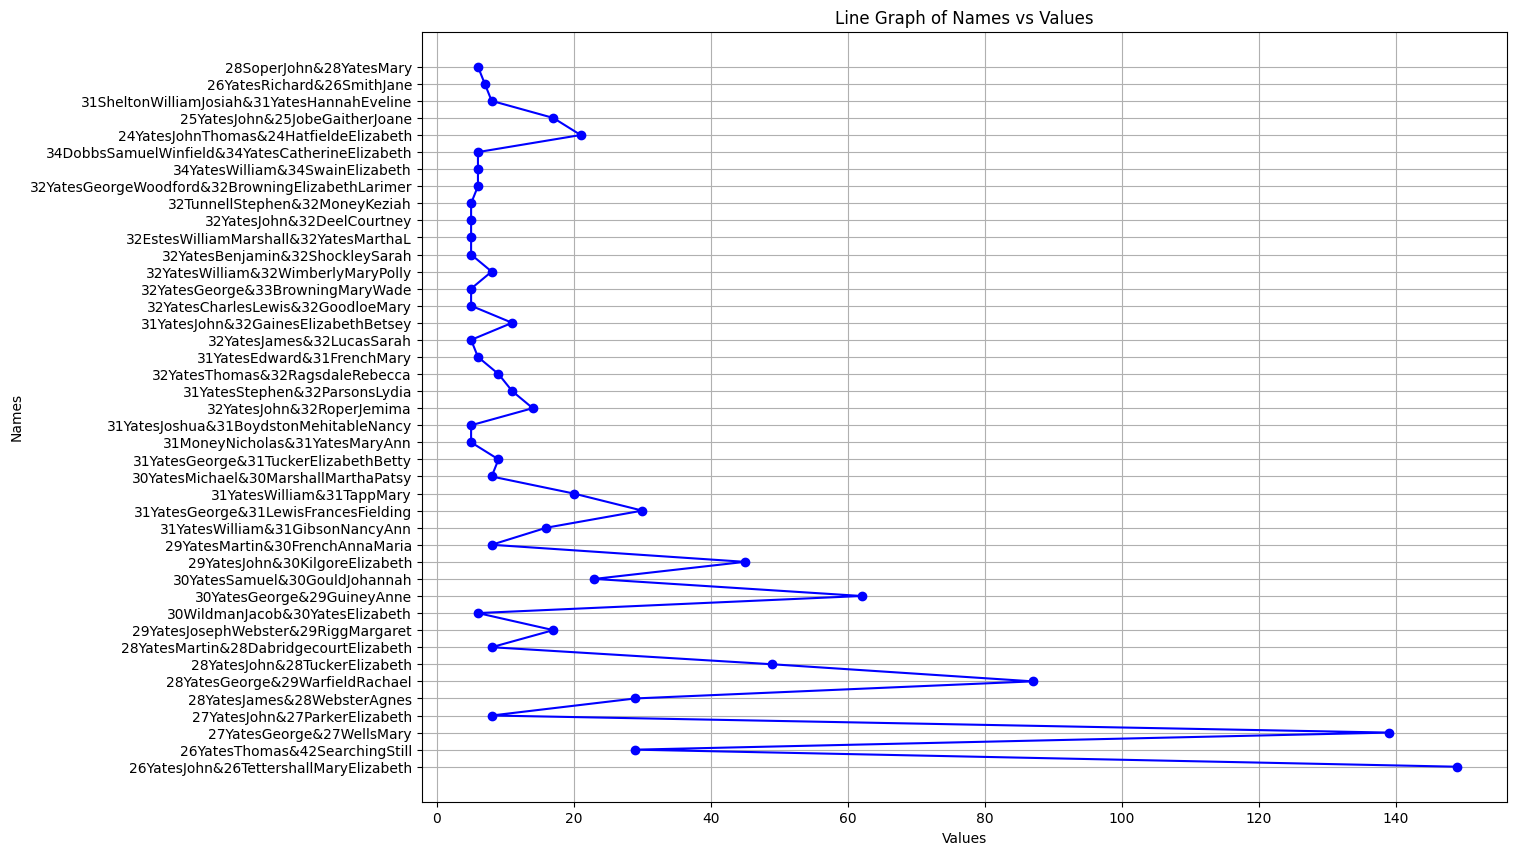

In [ ]:
#1644

import matplotlib.pyplot as plt

# Data from the provided text
data_dict = {
    "26YatesJohn&26TettershallMaryElizabeth": 149,
    "26YatesThomas&42SearchingStill": 29,
    "27YatesGeorge&27WellsMary": 139,
    "27YatesJohn&27ParkerElizabeth": 8,
    "28YatesJames&28WebsterAgnes": 29,
    "28YatesGeorge&29WarfieldRachael": 87,
    "28YatesJohn&28TuckerElizabeth": 49,
    "28YatesMartin&28DabridgecourtElizabeth": 8,
    "29YatesJosephWebster&29RiggMargaret": 17,
    "30WildmanJacob&30YatesElizabeth": 6,
    "30YatesGeorge&29GuineyAnne": 62,
    "30YatesSamuel&30GouldJohannah": 23,
    "29YatesJohn&30KilgoreElizabeth": 45,
    "29YatesMartin&30FrenchAnnaMaria": 8,
    "31YatesWilliam&31GibsonNancyAnn": 16,
    "31YatesGeorge&31LewisFrancesFielding": 30,
    "31YatesWilliam&31TappMary": 20,
    "30YatesMichael&30MarshallMarthaPatsy": 8,
    "31YatesGeorge&31TuckerElizabethBetty": 9,
    "31MoneyNicholas&31YatesMaryAnn": 5,
    "31YatesJoshua&31BoydstonMehitableNancy": 5,
    "32YatesJohn&32RoperJemima": 14,
    "31YatesStephen&32ParsonsLydia": 11,
    "32YatesThomas&32RagsdaleRebecca": 9,
    "31YatesEdward&31FrenchMary": 6,
    "32YatesJames&32LucasSarah": 5,
    "31YatesJohn&32GainesElizabethBetsey": 11,
    "32YatesCharlesLewis&32GoodloeMary": 5,
    "32YatesGeorge&33BrowningMaryWade": 5,
    "32YatesWilliam&32WimberlyMaryPolly": 8,
    "32YatesBenjamin&32ShockleySarah": 5,
    "32EstesWilliamMarshall&32YatesMarthaL": 5,
    "32YatesJohn&32DeelCourtney": 5,
    "32TunnellStephen&32MoneyKeziah": 5,
    "32YatesGeorgeWoodford&32BrowningElizabethLarimer": 6,
    "34YatesWilliam&34SwainElizabeth": 6,
    "34DobbsSamuelWinfield&34YatesCatherineElizabeth": 6,
    "24YatesJohnThomas&24HatfieldeElizabeth": 21,
    "25YatesJohn&25JobeGaitherJoane": 17,
    "31SheltonWilliamJosiah&31YatesHannahEveline": 8,
    "26YatesRichard&26SmithJane": 7,
    "28SoperJohn&28YatesMary": 6
}

# Create lists for names and values
names = list(data_dict.keys())
values = list(data_dict.values())

# Plotting the data
plt.figure(figsize=(14, 10))
plt.plot(values, names, marker='o', linestyle='-', color='b')
plt.xlabel('Values')
plt.ylabel('Names')
plt.title('Line Graph of Names vs Values')
plt.grid(True)
plt.show()


In [ ]:
#1605

import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side, Alignment, Font

# Load the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'
df = pd.read_excel(file_path, usecols=["Sort", "Ancestors"])

# Load the root parents from the processed file into a dictionary
root_parent_master_processed_path = '/content/root_parent_master_processed.xlsx'  # Update the path as needed
root_parent_master_processed_df = pd.read_excel(root_parent_master_processed_path)
root_parent_master_updated = root_parent_master_processed_df.set_index('root_parent_master').T.to_dict()

# Count and print the full complement of root parent pairs
full_complement_count = len(root_parent_master_updated)
print(f"Full complement of root parent pairs: {full_complement_count}")

# Define the fq_threshold value
fq_threshold = 5  # Set this value as needed

print(f"The Frequency Quotient threshold is set to: {fq_threshold}")

def parse_ancestors(df):
    """Parse the Ancestors column to determine the first parent pair."""
    first_parents = []
    for index, row in df.iterrows():
        nodes = row['Ancestors'].split('~~~')
        if nodes:
            first_parent_pair = nodes[0]
            first_parents.append(first_parent_pair)
    return set(first_parents)

def process_data(df, root_parent_master):
    """Load data, process it to expand 'Ancestors', calculate FQ and QI, and return a dictionary of results."""

    # Parse the Ancestors column to get the first parent pairs
    first_parents = parse_ancestors(df)

    # Prepare to expand and process
    expanded_data = []

    # Process each row to expand and mark root nodes
    for index, row in df.iterrows():
        nodes = row['Ancestors'].split('~~~')
        for i, node in enumerate(nodes):
            parent = nodes[i-1] if i > 0 else None
            expanded_data.append({
                'Parents': parent,
                'Offspring & Spouse': node,
                'Sort': row['Sort']  # Include 'Sort' in the expanded data
            })

    # Convert the list to a DataFrame
    expanded_df = pd.DataFrame(expanded_data)

    # Group by 'Parents' and 'Offspring & Spouse' and calculate FQ and QI
    grouped_df = expanded_df.groupby(['Parents', 'Offspring & Spouse']).agg(
        FQ=('Offspring & Spouse', 'size')
    ).reset_index()

    # Add 'DI' column by extracting the first two characters from the 'Parents' column
    grouped_df['DI'] = grouped_df['Parents'].apply(lambda x: int(x[:2]) if pd.notnull(x) and x[:2].isdigit() else None)

    # Calculate QI as the sum of all cM values divided by FQ, rounded to an integer
    grouped_df['QI'] = (grouped_df['FQ']).round().astype(int)

    # Mark root nodes based on first parent pairs and root_parent_master dictionary
    grouped_df['Root'] = grouped_df.apply(lambda x: 'Yes' if x['Parents'] in root_parent_master else '', axis=1)

    # Extract the prefix for segmenting the parents
    grouped_df['Prefix'] = grouped_df['Parents'].str.extract(r'(\d+)')

    # Ensure the Prefix column is treated as a string
    grouped_df['Prefix'] = grouped_df['Prefix'].astype(str)

    # Select relevant columns and filter results where FQ is greater than or equal to fq_threshold
    final_results_df = grouped_df[['Root', 'Parents', 'FQ', 'QI', 'Offspring & Spouse', 'Prefix']]
    final_results_df = final_results_df[final_results_df['FQ'] >= fq_threshold].copy()

    return final_results_df, len(df)

# Process the data
processed_data_df, total_records = process_data(df, root_parent_master_updated)

def sort_all_segments(data_dict):
    """Sort all segments within the data based on the FQ in descending order."""
    df = pd.DataFrame(data_dict)

    # Apply sorting within each segment
    sorted_df = df.groupby('Prefix', group_keys=False).apply(lambda x: x.sort_values(by='FQ', ascending=False)).reset_index(drop=True)

    return sorted_df

# Sort the data
sorted_data_df = sort_all_segments(processed_data_df.to_dict(orient='list'))

def assemble_descendants(df, total_records, fq_threshold):
    """Assemble descendants starting from root parents and include FQ, QI, and % Total."""
    assembled_data = []
    di_dict = {}  # Dictionary to store DI values for each ancestor

    for root, root_data in root_parent_master_updated.items():
        if root_data['FQ'] >= fq_threshold:  # Filter root parents by FQ threshold
            di_dict[root] = int(root[:2]) if root[:2].isdigit() else None  # Store the DI value for the root
            current_generation = [(root, 0)]
            assembled_data.append({
                'Root': 'Yes',
                'Parents and Trailing Descendants': root,
                'FQ': root_data['FQ'],
                'QI': root_data['QI'],
                '% Total': f"{round(root_data['FQ'] / total_records * 100)}%",
                'DI': di_dict[root]
            })
            while current_generation:
                next_generation = []
                for parent, depth in current_generation:
                    children = df[df['Parents'] == parent]
                    for _, child_row in children.iterrows():
                        # Use the DI value from the parent stored in the dictionary
                        di = di_dict[parent] if parent in di_dict else (int(child_row['Parents'][:2]) if child_row['Parents'][:2].isdigit() else None)
                        fq = child_row['FQ']
                        qi = child_row['QI']
                        percent_total = f"{round(fq / total_records * 100)}%"
                        descendant = f"{child_row['Offspring & Spouse']}"
                        assembled_data.append({
                            'Root': '',
                            'Parents and Trailing Descendants': descendant,
                            'FQ': fq,
                            'QI': qi,
                            '% Total': percent_total,
                            'DI': di
                        })
                        next_generation.append((child_row['Offspring & Spouse'], depth + 1))
                        di_dict[child_row['Offspring & Spouse']] = di  # Propagate the DI value to the next generation
                current_generation = next_generation

    assembled_df = pd.DataFrame(assembled_data)

    # Correctly assign the DI by ensuring it's treated as an integer where applicable
    assembled_df['DI'] = assembled_df['DI'].apply(lambda x: int(x) if pd.notnull(x) else None)

    return assembled_df

# Assemble descendants
descendants_df = assemble_descendants(pd.DataFrame(sorted_data_df), total_records, fq_threshold)

# Print the count of records each time
print(f"Total Records: {total_records}")
print(f"Filtered root parents count (FQ >= {fq_threshold}): {len(descendants_df[descendants_df['Root'] == 'Yes'])}")

# Output the entire DataFrame to the console
print(descendants_df.to_string(index=False))

def save_to_excel_with_styles(df, output_path):
    """Save the assembled data to an Excel file with the desired format and styles."""
    # Create an Excel file with openpyxl
    wb = Workbook()
    ws = wb.active

    # Adding rows to worksheet
    headers = ['Root', 'Parents and Trailing Descendants', 'FQ', 'QI', '% Total', 'DI']
    ws.append(headers)

    # Center-align the header labels
    header_alignment = Alignment(horizontal="center", vertical="center")
    header_font = Font(bold=True)
    thick = Side(border_style="thick", color="000000")

    for cell in ws[1]:
        cell.alignment = header_alignment
        cell.font = header_font
        cell.border = Border(top=thick, left=thick, right=thick, bottom=thick)

    # Add data rows to the worksheet
    for r in dataframe_to_rows(df, index=False, header=False):
        ws.append(r)

    # Adding borders and alignment for readability
    thin = Side(border_style="thin", color="000000")
    center_alignment = Alignment(horizontal="center", vertical="center")
    left_alignment = Alignment(horizontal="left", vertical="center")

    col_indices = {'FQ': 3, 'QI': 4, '% Total': 5, 'DI': 6}
    for row in ws.iter_rows(min_row=2, max_col=len(headers), max_row=ws.max_row):
        for cell in row:
            cell.border = Border(top=thin, left=thin, right=thin, bottom=thin)
            if cell.column in col_indices.values():
                cell.border = Border(top=thin, left=thick, right=thick, bottom=thin)
                cell.alignment = center_alignment
            elif cell.column == 2:
                cell.alignment = left_alignment

    # Save the workbook
    wb.save(output_path)
    print(f"Results successfully saved to {output_path}")

# Save the assembled data to an Excel file with styles
output_file_path = '/content/trailing_descendants-44.xlsx'  # Update the path as needed &#8203;:citation[oaicite:0]{index=0}&#8203;



Full complement of root parent pairs: 120
The Frequency Quotient threshold is set to: 5
Total Records: 1045
Filtered root parents count (FQ >= 5): 19
Root                  Parents and Trailing Descendants  FQ  QI % Total  DI
 Yes                    23YatesFrancis&23TichborneJane 507  65     49%  23
                       24YatesThomas&25StephensDorothy 506 506     48%  23
                26YatesJohn&26TettershallMaryElizabeth 443 443     42%  23
                        26YatesThomas&42SearchingStill  63  63      6%  23
                             27YatesGeorge&27WellsMary 399 399     38%  23
                         27YatesJohn&27ParkerElizabeth  37  37      4%  23
                           28YatesJames&28WebsterAgnes  63  63      6%  23
                       28YatesGeorge&29WarfieldRachael 284 284     27%  23
                         28YatesJohn&28TuckerElizabeth 107 107     10%  23
                    28PratherWilliamNathan&29YatesAnne   8   8      1%  23
                28YatesMa

In [ ]:
#testing 2

# Define the fq_threshold value
fq_threshold = 1
print(f"The Frequency Quotient threshold is set to: {fq_threshold}")

import csv
import glob
from gedcom.element.individual import IndividualElement
from gedcom.parser import Parser
import pandas as pd
from datetime import datetime
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side, Alignment, PatternFill
import os

# Hard-coded interval scheme
interval_scheme = [
    (1000, 1), (1025, 2), (1050, 3), (1075, 4), (1100, 5),
    (1125, 6), (1150, 7), (1175, 8), (1200, 9), (1225, 10),
    (1250, 11), (1275, 12), (1300, 13), (1325, 14), (1350, 15),
    (1375, 16), (1400, 17), (1425, 18), (1450, 19), (1475, 20),
    (1500, 21), (1525, 22), (1550, 23), (1575, 24), (1600, 25),
    (1625, 26), (1650, 27), (1675, 28), (1700, 29), (1725, 30),
    (1750, 31), (1775, 32), (1800, 33), (1825, 34), (1850, 35),
    (1875, 36), (1900, 37), (1925, 38), (1950, 39), (1975, 40),
    (2000, 41), (2025, 42), (2050, 43), (2075, 44)
]

# Function to assign interval based on birthdate
def assign_interval(birth_date, interval_scheme):
    if pd.isnull(birth_date):
        return 99
    try:
        birth_year = int(birth_date[-4:])
    except ValueError:
        return 99
    for year, interval in interval_scheme:
        if birth_year <= year:
            return interval
    return 99

class GedcomDataset:
    def __init__(self, gen_person):
        self.gen_person = gen_person
        self.extractable_detail = {}
        self.anchor_gen1 = None  # Initialize anchor_gen1 here

    def add_extractable_detail(self, key, value):
        self.extractable_detail[key] = value

    def get_gen_person(self):
        name = self.extractable_detail.get('NAME', '')
        parts = name.split('/', 1)
        first_name = parts[0].split(' ')[0]
        last_name = parts[1].rstrip('/') if len(parts) > 1 else ""
        self.anchor_gen1 = last_name.replace(" ", "") + first_name.replace(" ", "")
        global anchor_gen1  # Declare that we're using the global variable
        anchor_gen1 = self.anchor_gen1  # Update the global variable
        return self.gen_person.strip('@')

    def get_anchor_gen1(self):
        return self.anchor_gen1

    def get_extractable_NPFX(self):
        return self.extractable_detail.get('NPFX', '')

    def get_extractable_cm(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            cm_value = npfx_value.split('&')[0].strip()
        else:
            cm_value.strip()
        try:
            int(cm_value)
            return cm_value
        except ValueError:
            return 'error'

    def get_extractable_sort(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            sort_value = npfx_value.split('&')[1].strip()
            return sort_value
        else:
            return ''

    def get_extractable_FAMC(self):
        return self.extractable_detail.get('FAMC', '').strip('@')

    def get_birth_date(self):
        return self.extractable_detail.get('BIRTH_DATE', '')

    def get_fams(self):
        return self.extractable_detail.get('FAMS', '').strip('@')

# Set of excluded record IDs
excluded_ids = {
    'I47640', 'I55585', 'I47666', 'I55586', 'I47570', 'I55587',
    'I47569', 'I47641', 'I47571', 'I47572', 'I47549', 'I47550',
    'I47573', 'I55588', 'I47548', 'I47551', 'I47553', 'I24502', 'I24503',
    'I47659', 'I48070', 'I47660', 'I48129', 'I48130', 'I48126', 'I48127'
}

# Function definitions
def extract_id(record):
    id_start = record.find('@') + 1
    id_end = record.find('@', id_start)
    return record[id_start:id_end]

def extract_name(record):
    name_start = record.find('1 NAME ') + 6
    name_end = record.find('\n', name_start)
    name = record[name_start:name_end]
    first_name, last_name = name.split('/', 1)
    first_name = first_name[:30]
    last_name = last_name[:30].rstrip('/')
    return last_name.replace(" ", "") + first_name.replace(" ", "")

name_to_id = {}   # Global dictionary to hold name to ID mapping

class Gedcom:
    def __init__(self, file_name):
        self.file_name = file_name
        self.gedcom_datasets = []
        self.filter_pool = []

    @staticmethod
    def get_standard_name(file_path):
        file_name = file_path.split('/')[-1]
        if '.' in file_name:
            file_name = file_name.rsplit('.', 1)[0]
        standard_name = file_name.replace(' ', '_').lower()
        return standard_name

    def parse_gedcom(self):
        global name_to_id  # Declare name_to_id as global to modify it
        with open(self.file_name, 'r', encoding='utf-8-sig') as f:
            gedcom_lines = f.readlines()
        current_dataset = None
        npfx_count = 0
        total_count = 0

        for line in gedcom_lines:
            parts = line.strip().split(' ', 2)
            level = int(parts[0])
            tag = parts[1]
            value = parts[2] if len(parts) > 2 else None

            if level == 0 and tag.startswith('@') and tag.endswith('@') and value == 'INDI':
                individual_id = tag.strip('@')
                if individual_id in excluded_ids:
                    continue  # Skip processing for the excluded IDs

                total_count += 1
                current_dataset = GedcomDataset(tag)
                self.gedcom_datasets.append(current_dataset)

                # Populate name_to_id
                individual_name = current_dataset.get_anchor_gen1()
                individual_id = current_dataset.get_gen_person()
                name_to_id[individual_name] = individual_id

            elif current_dataset is not None:
                if level == 1 and tag in ['NAME', 'FAMC', 'FAMS', 'BIRT', 'SEX']:
                    current_key = tag
                    current_dataset.add_extractable_detail(current_key, value)

                elif level == 2 and tag == 'DATE' and current_key == 'BIRT':
                    current_dataset.add_extractable_detail('BIRTH_DATE', value)

                elif level == 2 and tag == 'NPFX':
                    npfx_count += 1
                    current_dataset.add_extractable_detail(tag, value)

        print(f'GEDCOM contained {total_count} total records')
        print(f'Records tagged and filtered by NPFX: {npfx_count}')

        # First level of filtering: Filter those with NPFX
        for dataset in self.gedcom_datasets:
            if dataset.get_extractable_NPFX():
                self.filter_pool.append(dataset)

        # Remove excluded IDs from filter_pool
        self.filter_pool = [ds for ds in self.filter_pool if ds.get_gen_person() not in excluded_ids]

        # Check if manual filtering should be applied
        manual_filter_activated = True  # or False depending on your situation

        # Second level of filtering: Apply manual filter from Excel sheet
        if manual_filter_activated:
            try:
                df = pd.read_excel('filtered_ids.xlsx')
            except FileNotFoundError:
                print("filtered_ids.xlsx not found. Skipping second-level manual filter.")
            else:
                manual_filtered_ids = set(df['ID'])
                print(f"Manual filter IDs loaded: {len(manual_filtered_ids) - 1}")

                self.filter_pool = [dataset for dataset in self.filter_pool if dataset.get_gen_person() in manual_filtered_ids]
                print(f"After manual filter, total records: {len(self.filter_pool)}")

    def apply_manual_filter(self):
        manual_filter_activated = True
        if manual_filter_activated:
            try:
                df = pd.read_excel('filtered_ids.xlsx')
                manual_filtered_ids = set(df['ID'].astype(str))  # Ensure IDs are strings
                print(f"Manual filter IDs loaded: {len(manual_filtered_ids)}")
            except FileNotFoundError:
                print("filtered_ids.xlsx not found. Skipping second-level manual filter.")
            else:
                # Debug output to verify IDs before filtering
                print("IDs before manual filter:", [ds.get_gen_person() for ds in self.filter_pool][:10])
                self.filter_pool = [ds for ds in self.filter_pool if str(ds.get_gen_person()) in manual_filtered_ids]
                print("IDs after manual filter:", [ds.get_gen_person() for ds in self.filter_pool][:10])
                print(f"After manual filter, total records: {len(self.filter_pool)}")

    def check_and_apply_exclusion_filter(self):
        """Apply exclusion filter if '/exclude_ids.xlsx' is present."""
        file_path = '/content/exclude_ids.xlsx'  # Updated path
        if os.path.exists(file_path):
            try:
                df_exclude = pd.read_excel(file_path)
                if 'ID' in df_exclude.columns:
                    exclude_ids = set(df_exclude['ID'].astype(str))  # Ensure conversion to string
                    print(f"Exclusion filter IDs loaded: {len(exclude_ids)}")
                    print(f"Sample of IDs to exclude: {list(exclude_ids)[:5]}")  # Print some sample IDs
                    # Apply the exclusion filter
                    initial_count = len(self.filter_pool)
                    self.filter_pool = [ds for ds in self.filter_pool if str(ds.get_gen_person()) not in exclude_ids]
                    print(f"Excluded {initial_count - len(self.filter_pool)} records based on exclusion IDs.")
                else:
                    print("Column 'ID' not found in the Excel file.")
            except Exception as e:
                print(f"Failed to apply exclusion filter: {str(e)}")
        else:
            print(f"No exclusion filter applied, '{file_path}' not found. Check the path and ensure the file is uploaded to Colab.")

def input_prime_surname(last_prime_surname=None):
    if last_prime_surname:
        last_name = input(f"Enter prime_surname (default: {last_prime_surname}): ")
        if not last_name:
            last_name = last_prime_surname
    else:
        last_name = input("Enter prime_surname: ")
    return last_name

def select_gedcom_file():
    gedcom_files = glob.glob('*.ged')
    if not gedcom_files:
        print("No GEDCOM files found.")
        return None

    print("Automatically selecting the first GEDCOM file.")
    return gedcom_files[0]

    while True:
        try:
            selected_num = int(input("Enter the number of the GEDCOM file you want to use: "))
            if 1 <= selected_num <= len(gedcom_files):
                return gedcom_files[selected_num - 1]
            else:
                print("Invalid number. Please enter a valid number from the list.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

gedcom_file_path = select_gedcom_file() # Call the function to let the user select the GEDCOM file
if gedcom_file_path:
    # Use the selected GEDCOM file path to create an instance of the Gedcom class
    gedcom_instance = Gedcom(gedcom_file_path)
    gedcom_instance.parse_gedcom()

    individuals = []  # Initialize the list of individuals

    for dataset in gedcom_instance.filter_pool:    # Iterate over the filter_pool list, add each last name and ID to list
        individual_id = dataset.get_gen_person()
        last_name = dataset.get_anchor_gen1()
        individuals.append((last_name, individual_id))

    print(f'Records tagged and filtered by NPFX: {len(individuals)}')

    with open(gedcom_file_path, 'r') as file:    # Read the GEDCOM file and split it into individual and family records
        data = file.read()
    data = data.split('\n0 ')
    records = {extract_id(record): record for record in data}

def has_both_parents(records, mother_id, father_id):
    return mother_id in records and father_id in records

visited_pairs = set()
generation_table = []

# Function to find parents, ensuring excluded IDs are not processed
def find_parents(individual_id, generation, records):
    if individual_id in excluded_ids or individual_id not in records:
        return
    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]
    if famc_id not in records:
        return

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if mother_id and mother_id in records and father_id and father_id in records:
        parent_pair = (father_id, mother_id)
        if parent_pair not in visited_pairs:
            visited_pairs.add(parent_pair)
            generation_table.append((generation, parent_pair))

    if mother_id:
        find_parents(mother_id, generation + 1, records)

    if father_id:
        find_parents(father_id, generation + 1, records)

# Function to find distant ancestors, ensuring excluded IDs are not processed
def find_distant_ancestors(individual_id, records, path=None):
    if individual_id in excluded_ids:
        return []
    path = path if path is not None else []
    if path is None:
        path = [individual_id]
    else:
        path.append(individual_id)

    if individual_id not in records:
        return []

    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]

    if famc_id not in records:
        return [path]

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if father_id is None and mother_id is None:
        return [path]

    paths = []
    if father_id and father_id not in excluded_ids:
        new_path = list(path)
        paths.extend(find_distant_ancestors(father_id, records, new_path))

    if mother_id and mother_id not in excluded_ids:
        new_path = list(path)
        paths.extend(find_distant_ancestors(mother_id, records, new_path))

    return paths

# Example usage after parsing and filtering
gedcom_instance.parse_gedcom()

filtered_datasets = gedcom_instance.filter_pool

def calculate_score(distant_ancestors_paths, records):
    name_paths = []
    for path in distant_ancestors_paths:
        name_path = [extract_name(records.get(id, '')) for id in path]
        name_paths.append(name_path)

    path_scores = {}
    for idx, name_path in enumerate(name_paths):
        score = 0
        for generation, name in enumerate(name_path):
            if 'Yates' in name:
                score += 1 * (generation + 1)
        path_scores[idx] = score

    if path_scores:
        winning_path_index = max(path_scores, key=path_scores.get)
        winning_path_score = path_scores[winning_path_index]
        winning_path_names = name_paths[winning_path_index]
        winning_path_ids = distant_ancestors_paths[winning_path_index]
    else:
        winning_path_index = None
        winning_path_score = 0
        winning_path_names = []
        winning_path_ids = []

    return winning_path_score, winning_path_names, winning_path_ids

def filter_ancestral_line(winning_path_ids, generation_table):
    matching_table = []
    for generation, pair in generation_table:
        id1, id2 = pair
        if id1 in winning_path_ids or id2 in winning_path_ids:
            matching_table.append((generation, pair))
    return matching_table

def process_individual(individual_id, gedcom_instance, records, interval_scheme):
    global generation_table
    global visited_pairs
    global anchor_gen1  # Declare that we're using the global variable

    generation_table = []
    visited_pairs = set()

    find_parents(individual_id, 1, records)
    distant_ancestors_paths = find_distant_ancestors(individual_id, records)
    winning_path_score, winning_path_names, winning_path_ids = calculate_score(distant_ancestors_paths, records)
    filtered_ancestral_line = filter_ancestral_line(winning_path_ids, generation_table)
    filtered_ancestral_line.sort(key=lambda x: x[0])
    filtered_ancestral_line_names = []
    birth_date = None  # Initialize birth_date

    # Extract cm_value, sort_value, anchor_gen1, and birth_date
    for dataset in gedcom_instance.filter_pool:
        if dataset.get_gen_person() == individual_id:
            cm_value = dataset.get_extractable_cm()
            sort_value = dataset.get_extractable_sort()
            anchor_gen1 = dataset.get_anchor_gen1()  # Update anchor_gen1 locally here
            birth_date = dataset.extractable_detail.get('BIRTH_DATE')  # Get birth date
            break
    else:
        cm_value = 'N/A'
        sort_value = 'N/A'
        birth_date = 'N/A'  # Set default if not found

    if anchor_gen1 is not None:
        filtered_ancestral_line_names.insert(0, anchor_gen1)

    ancestors_data = []

    # Extract ancestor information and concatenate name with Date Interval
    for generation, pair in filtered_ancestral_line:
        ancestor_details = []
        for ancestor_id in pair:
            if ancestor_id in records:
                ancestor_record = records[ancestor_id]
                ancestor_name = extract_name(ancestor_record)
                ancestor_sex = 'M' if '1 SEX M' in ancestor_record else 'F' if '1 SEX F' in ancestor_record else ''
                birth_date_start = ancestor_record.find('2 DATE ') + 7
                birth_date_end = ancestor_record.find('\n', birth_date_start)
                ancestor_birth_date = ancestor_record[birth_date_start:birth_date_end].strip() if birth_date_start != -1 else 'N/A'
                ancestor_date_interval = assign_interval(ancestor_birth_date, interval_scheme)
                ancestor_details.append({
                    'ID': ancestor_id,
                    'Name': ancestor_name,
                    'Sex': ancestor_sex,
                    'Birth Date': ancestor_birth_date,
                    'Date Interval': ancestor_date_interval
                })
        if ancestor_details:
            name_with_interval_1 = f"{ancestor_details[0]['Date Interval']}{ancestor_details[0]['Name']}"
            name_with_interval_2 = f"{ancestor_details[1]['Date Interval']}{ancestor_details[1]['Name']}" if len(ancestor_details) > 1 else '99Unknown'
            combined_name_with_interval = f"{name_with_interval_1}&{name_with_interval_2}"
            ancestors_data.append(combined_name_with_interval)

    # Reverse the order to start with the oldest ancestor
    ancestors_data.reverse()
    filtered_ancestral_line_str = "~~~".join(ancestors_data)

    # Assign date interval
    date_interval = assign_interval(birth_date, interval_scheme)

    # Create first-pair by splitting the ancestors full line
    first_pair = ancestors_data[0] if ancestors_data else ''

    individual_data = {
        'Sort': sort_value,
        'ID': individual_id,
        'Name': extract_name(records[individual_id]),
        'Sex': dataset.extractable_detail.get('SEX', ''),
        'Birth Date': birth_date,
        'Date Interval': date_interval,
        'FAMS': dataset.get_fams(),
        'FAMC': dataset.get_extractable_FAMC(),
        'cM': cm_value,
        'First Pair': first_pair,  # Add first-pair here
        'Ancestors': filtered_ancestral_line_str  # Add ancestors data to individual data
    }

    return individual_data, filtered_ancestral_line_str

# Initialize the dictionary to store individual data
DNA_Study_Library = {}

The Frequency Quotient threshold is set to: 1
Automatically selecting the first GEDCOM file.
GEDCOM contained 57597 total records
Records tagged and filtered by NPFX: 1299
Manual filter IDs loaded: 498
After manual filter, total records: 499
Records tagged and filtered by NPFX: 499
GEDCOM contained 57597 total records
Records tagged and filtered by NPFX: 1299
Manual filter IDs loaded: 498
After manual filter, total records: 1497


In [ ]:
# good_/content/Ancestor_Pair_Frequency.xlsx

import pandas as pd

# Load the Excel file
file_path = '/content/DNA_Study_Library.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the data to understand its structure
print(data.head())

# Extract the relevant column with ancestor lines
# Assuming the column name is 'Ancestors'
ancestors = data['Ancestors']

# Initialize an empty dictionary to store the frequency of each ancestor pair
ancestor_counts = {}

# Split each ancestor line by the '~~~' separator and count occurrences
for line in ancestors:
    if pd.notna(line):
        pairs = line.split('~~~')
        for pair in pairs:
            if pair in ancestor_counts:
                ancestor_counts[pair] += 1
            else:
                ancestor_counts[pair] = 1

# Convert the dictionary to a DataFrame for better visualization
ancestor_counts_df = pd.DataFrame(list(ancestor_counts.items()), columns=['Ancestor Pair', 'Frequency'])

# Sort the DataFrame by frequency in descending order
ancestor_counts_df = ancestor_counts_df.sort_values(by='Frequency', ascending=False)

# Display the frequency of each ancestor pair
print(ancestor_counts_df)

# Save the result to a new Excel file if needed
ancestor_counts_df.to_excel('Ancestor_Pair_Frequency.xlsx', index=False)



           Sort    ID                Name Sex   Birth Date  Date Interval  \
0  yates,ronald   I73    YatesJamesRobert   M  24 MAR 2018             42   
1  yates,ronald   I80   YatesPatriciaLynn   F   1 JUL 1951             40   
2  yates,ronald   I82  YatesTimothyJoseph   M  15 DEC 2023             42   
3  yates,ronald   I84     YatesAndreaLynn   F  17 JUN 1952             40   
4  yates,ronald  I613    WaldrupGlendaKay   F  28 APR 2020             42   

   FAMS  FAMC    cM                        First Pair  \
0   F90    F6  1047  30YatesBenjamin&42SearchingStill   
1   F98    F3  2585  30YatesBenjamin&42SearchingStill   
2   F99   F85   901  30YatesBenjamin&42SearchingStill   
3  F101   F85   872  30YatesBenjamin&42SearchingStill   
4  F523  F514    91  30YatesBenjamin&42SearchingStill   

                                           Ancestors  
0  30YatesBenjamin&42SearchingStill~~~31YatesBenj...  
1  30YatesBenjamin&42SearchingStill~~~31YatesBenj...  
2  30YatesBenjamin&42Searchin